In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
path = '/home/ricardo/TCC/'

In [3]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

# Normalizing Data

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Separating the Data in anomaly and not anomaly

In [5]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

# Balanced Data

### Verifying how unbalanced is our dataset

Text(0.5, 1.0, '8.951238929246692')

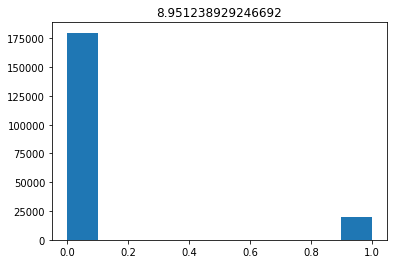

In [6]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

### To balance the data we will eliminate some not anomaly samples

In [7]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)

### Verifying if it is balanced now

Text(0.5, 1.0, '2.2377848542143495')

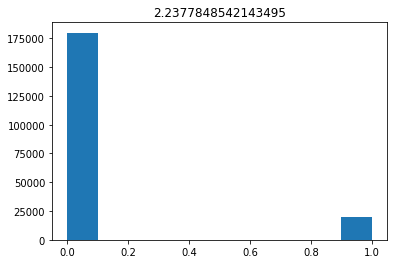

In [8]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

# Separating in Train, Val and Test data

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [10]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

### Verifying the size of each dataframe

In [11]:
print('Resampled dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_test))
print('Resampled dataset shape %s' % Counter(y_val))

Resampled dataset shape Counter({0: 31412, 1: 14139})
Resampled dataset shape Counter({0: 6784, 1: 2977})
Resampled dataset shape Counter({0: 6779, 1: 2982})


# Importing some metrics to evaluating the models.

In [12]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# CatBoostClassifier

In [13]:
model = CatBoostClassifier(iterations=8000,eval_metric= 'F1',random_seed=42,verbose=False)
model.fit(x_data[0],y_data[0])

In [18]:
model.save_model(path+'/Undersampling/Boost/CatBoostClassifier')

- ###  Analysing the performance with differents thresholds

In [57]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [58]:
def predict_threshold(y_prob,threshold):
    y_hat = []
    for i in range(len(y_prob)):
        if y_prob[i]>threshold:
            y_hat.append(1)
        else:
            y_hat.append(0)
    return y_hat

precision values: [0.44468491406747296, 0.46122002914293286, 0.47741025993673497, 0.4946005864263749, 0.5100099914887318, 0.5260029147810079, 0.5411829959193376, 0.5565925743992796, 0.5717364662130753, 0.586991586381272, 0.6024621467403514, 0.6173639392817475, 0.6318673464525659, 0.6458170062695925, 0.659624886558435, 0.6733119304059652, 0.6867732172250837, 0.698792559556184, 0.7109514260249554, 0.723185759926974, 0.7355260851784775, 0.7486666267154072, 0.7602428851815506, 0.7697801165194512, 0.7806736680327869, 0.7892121608368748, 0.7990919409761634, 0.8103236378533388, 0.818733012753502, 0.8287139294620591, 0.8379912663755459, 0.8462336892052195, 0.8529700354743754, 0.8597396595548025, 0.8689362371255602, 0.8766870179948586, 0.8842778643483966, 0.8905176746523705, 0.8966549747625974, 0.9030652344773382, 0.9081759885999288, 0.9142310844031686, 0.9189715982921849, 0.9235940162847945, 0.9287163141118516, 0.9339259259259259, 0.9387403807209397, 0.9432888336955397, 0.9472848523340743, 0.9

Normalized confusion matrix
[[0.9583917  0.0416083 ]
 [0.24810807 0.75189193]]
Normalized confusion matrix
[[0.96154336 0.03845664]
 [0.25871702 0.74128298]]
Normalized confusion matrix
[[0.96466319 0.03533681]
 [0.26861871 0.73138129]]
Normalized confusion matrix
[[0.96717815 0.03282185]
 [0.27880331 0.72119669]]
Normalized confusion matrix
[[0.97001146 0.02998854]
 [0.28983662 0.71016338]]
Normalized confusion matrix
[[0.97220807 0.02779193]
 [0.29973831 0.70026169]]
Normalized confusion matrix
[[0.97430918 0.02569082]
 [0.31006436 0.68993564]]
Normalized confusion matrix
[[0.97650579 0.02349421]
 [0.31996605 0.68003395]]
Normalized confusion matrix
[[0.97870241 0.02129759]
 [0.33121154 0.66878846]]
Normalized confusion matrix
[[0.98073984 0.01926016]
 [0.34429592 0.65570408]]
Normalized confusion matrix
[[0.98255444 0.01744556]
 [0.35532923 0.64467077]]
Normalized confusion matrix
[[0.98414619 0.01585381]
 [0.36706981 0.63293019]]
Normalized confusion matrix
[[0.98538775 0.01461225]

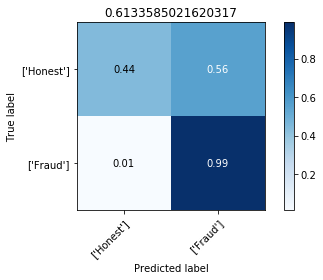

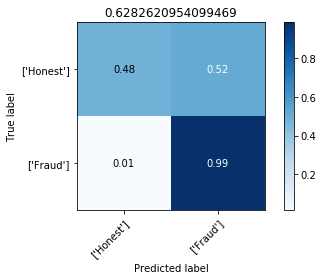

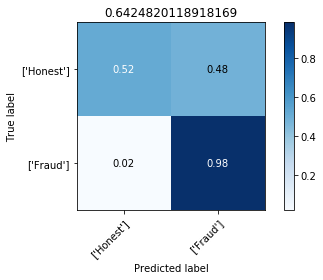

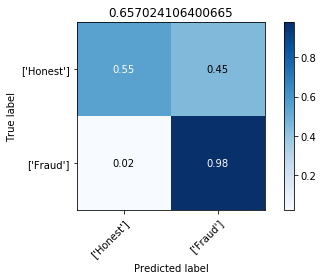

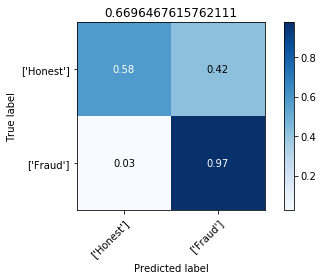

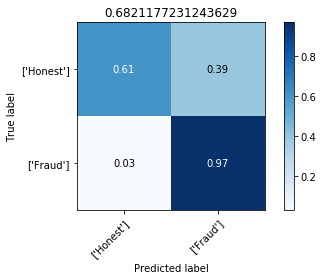

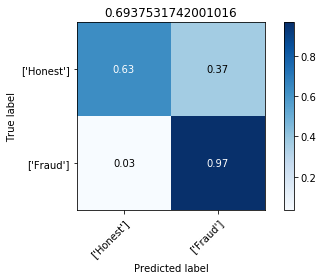

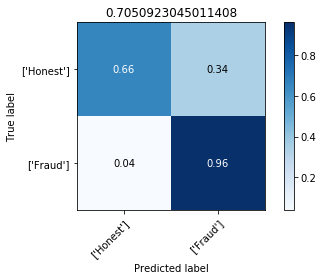

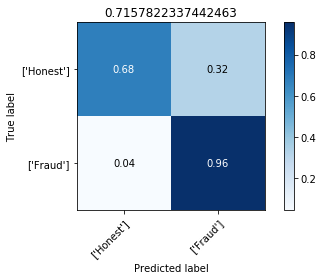

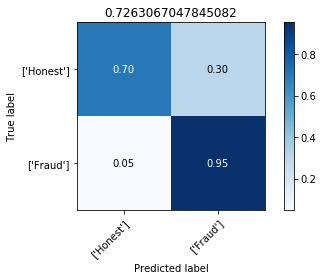

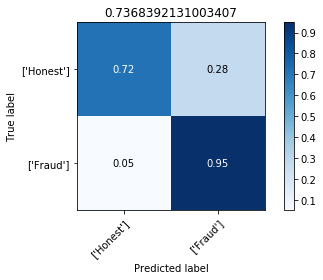

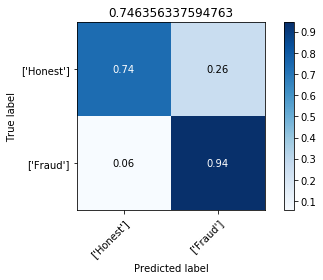

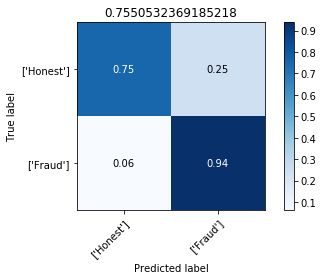

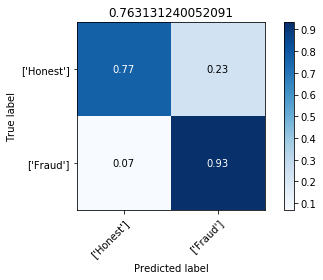

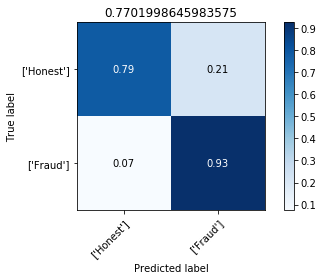

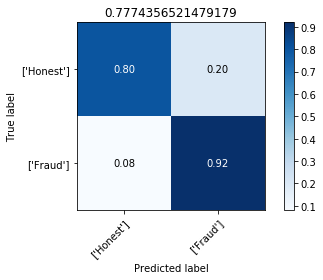

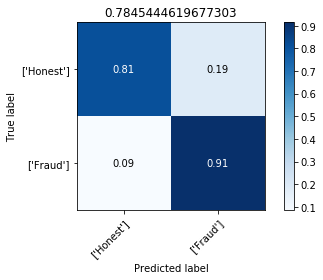

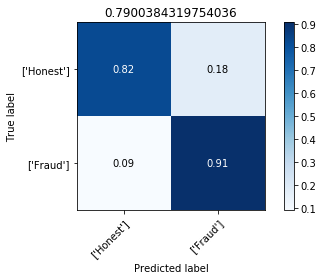

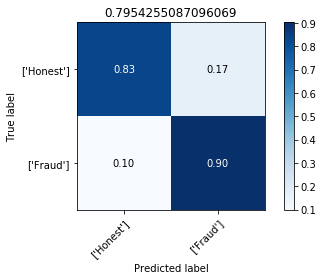

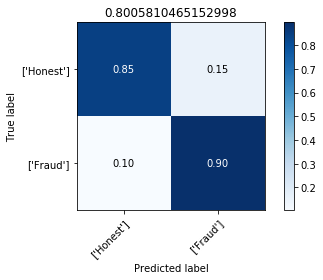

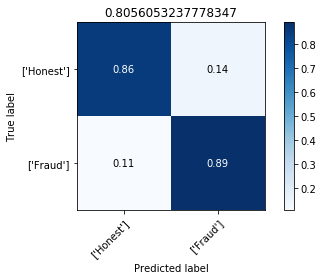

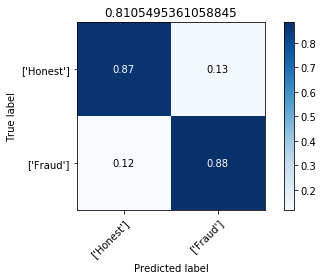

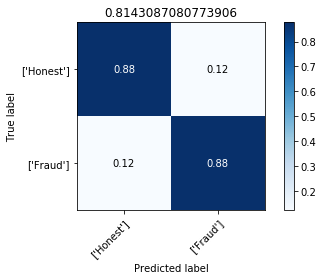

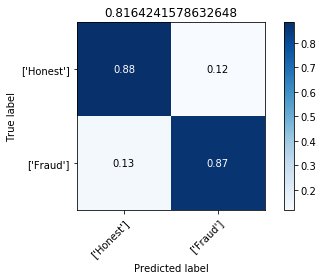

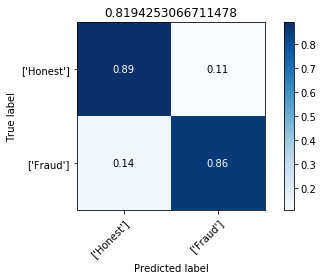

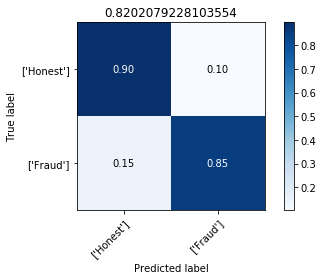

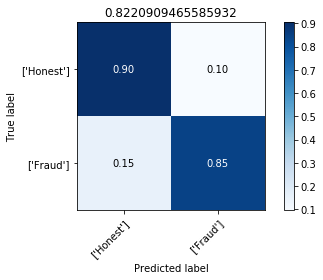

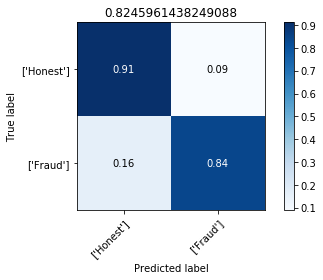

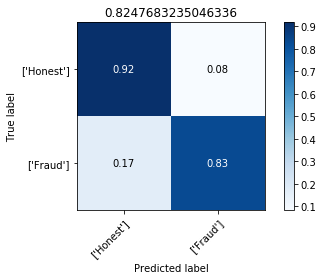

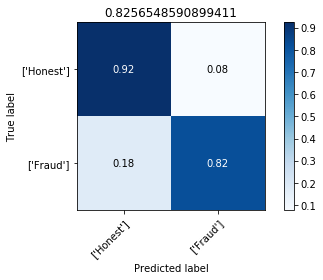

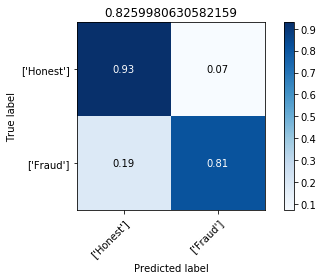

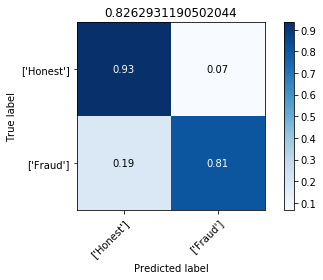

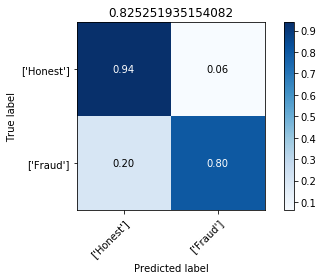

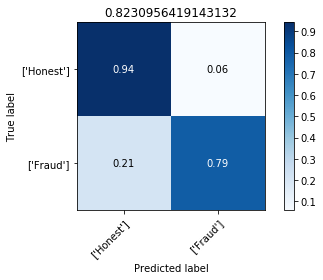

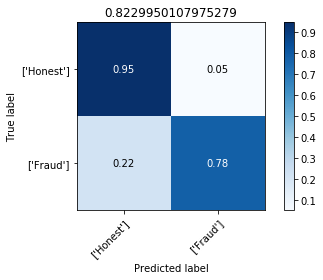

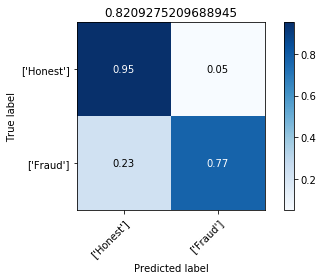

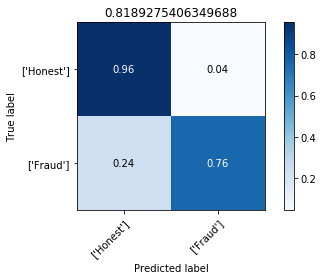

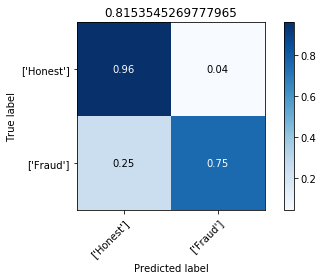

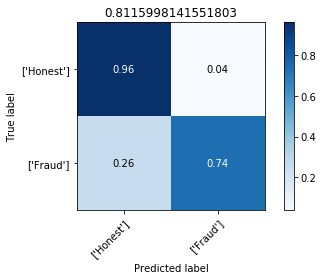

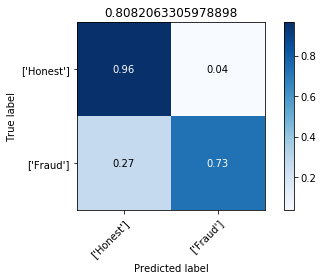

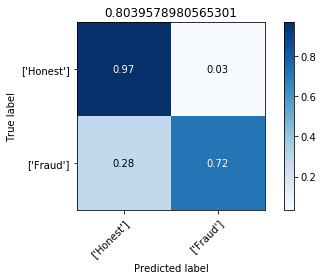

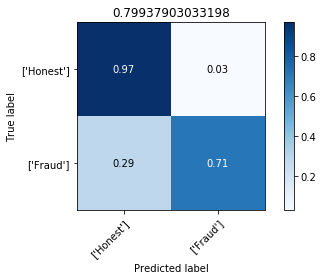

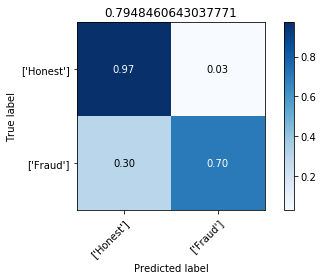

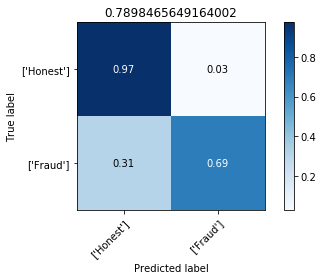

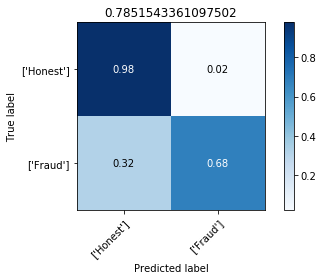

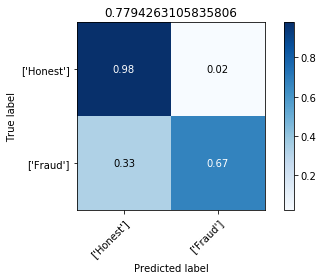

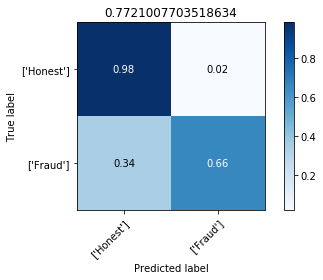

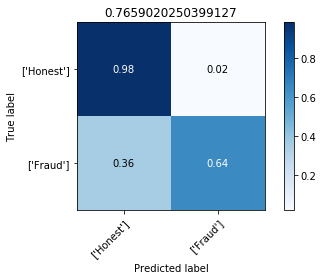

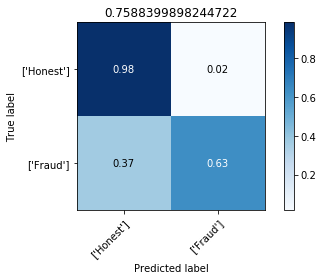

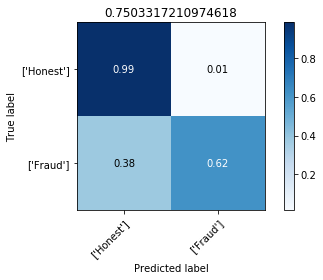

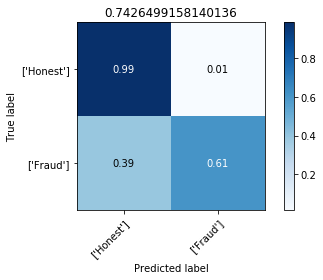

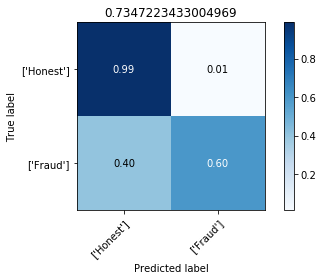

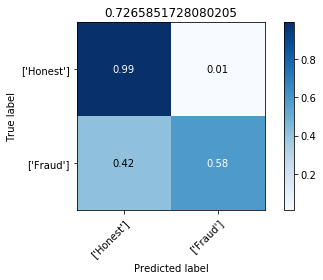

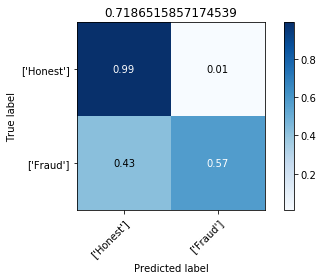

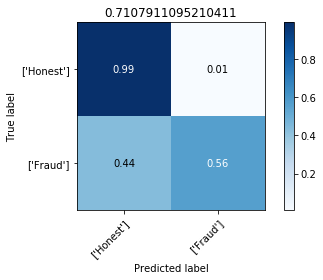

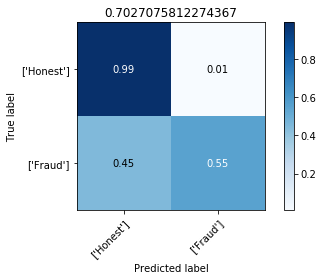

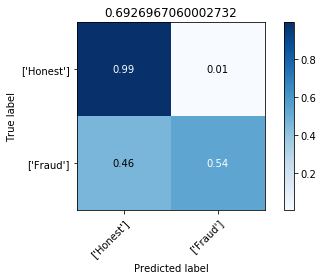

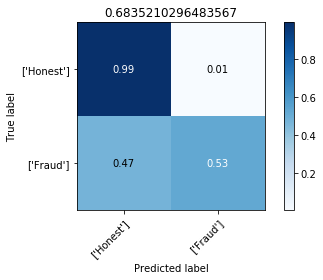

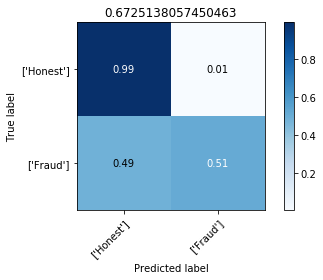

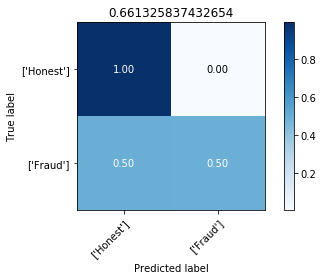

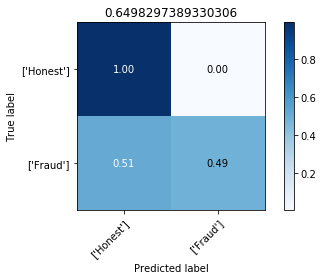

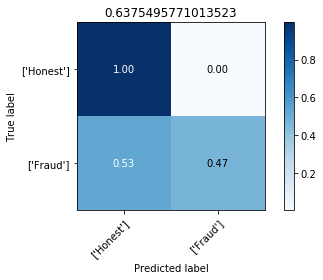

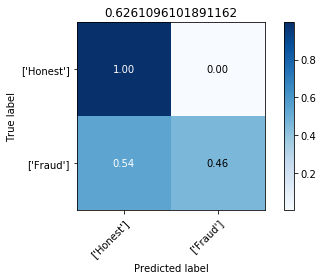

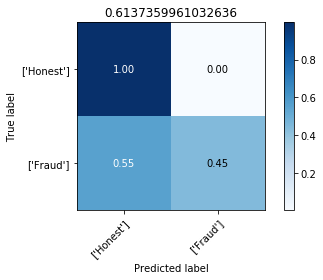

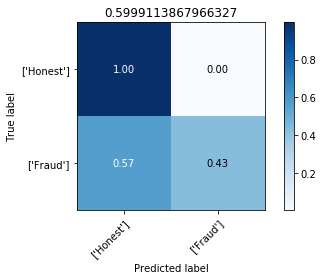

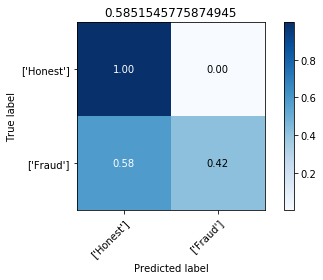

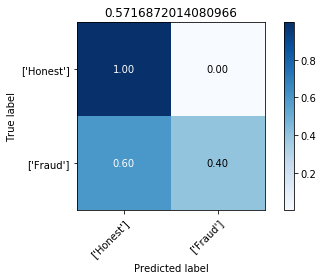

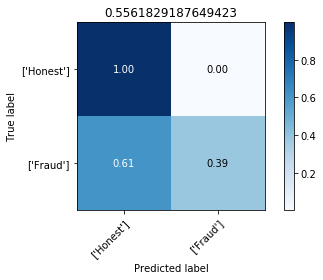

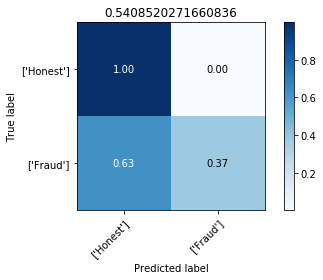

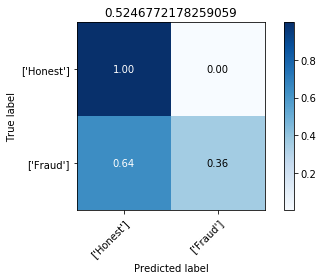

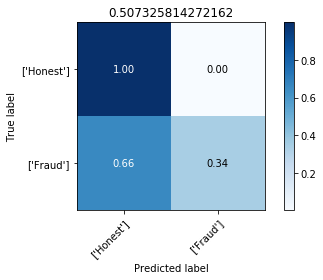

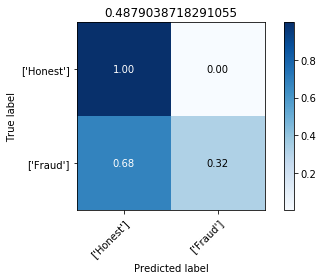

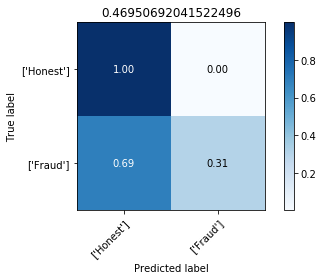

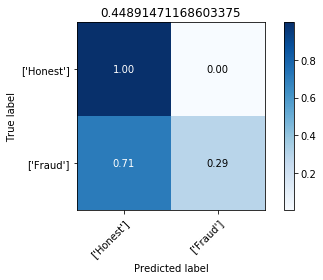

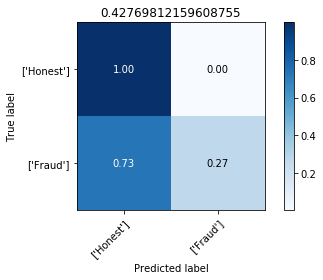

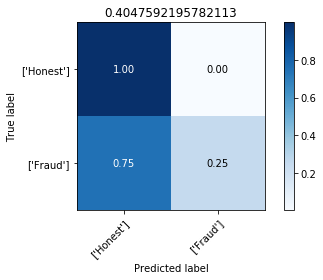

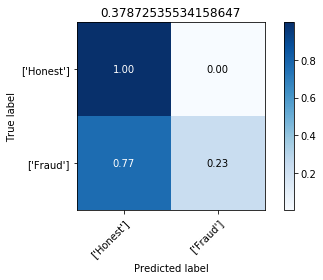

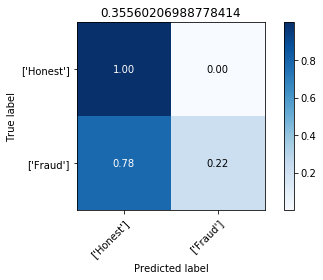

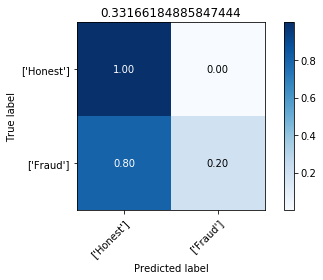

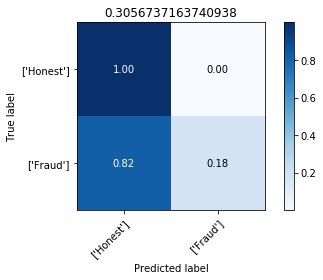

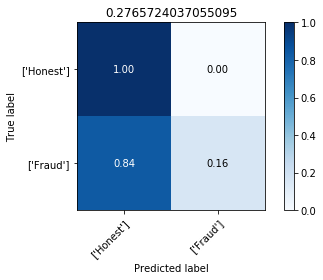

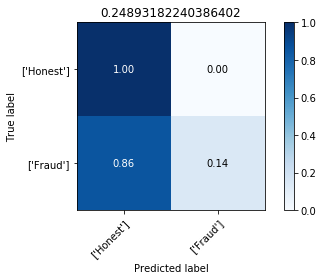

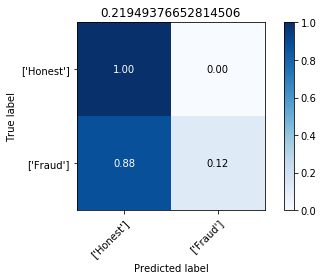

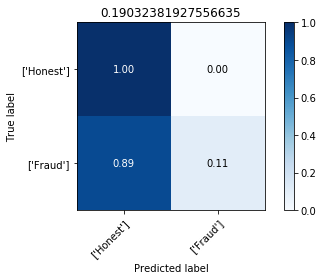

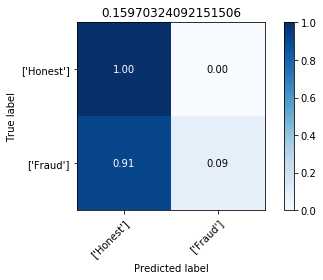

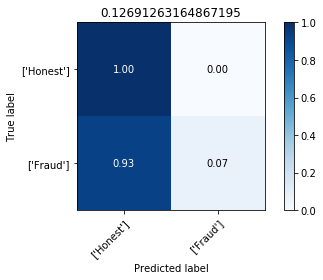

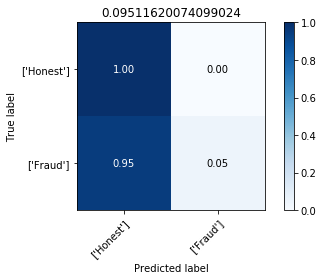

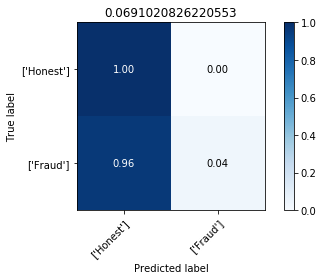

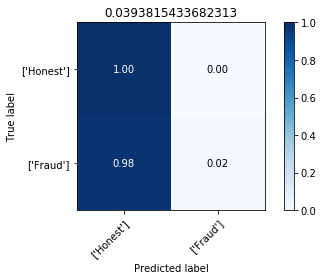

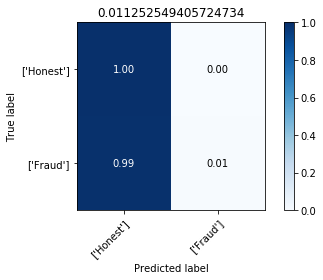

In [61]:
prob = np.ravel(model.predict_proba(x_data[0])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

- ### Predicting with the best Threshold

In [72]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])[:,1]),
                                   threshold_list[f1.index(max(f1))]))

Normalized confusion matrix
[[0.93397428 0.06602572]
 [0.19272933 0.80727067]]
Normalized confusion matrix
[[0.88036584 0.11963416]
 [0.29610999 0.70389001]]
Normalized confusion matrix
[[0.88944575 0.11055425]
 [0.29526369 0.70473631]]


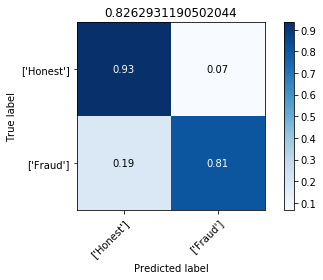

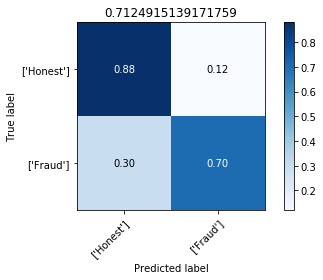

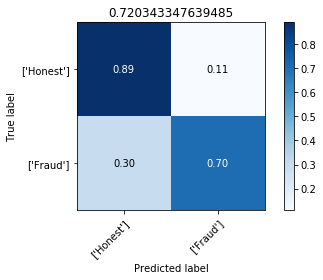

In [73]:
for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

# LGBMClassifier

In [75]:
model = lgb.LGBMClassifier(n_estimators=8000,n_jobs = -1)
model.fit(x_data[0],y_data[0])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=8000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [77]:
model.booster_.save_model(path+'/Undersampling/Boost/models/LGBMClassifier')

- ###  Analysing the performance with differents thresholds

precision values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
f1 values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

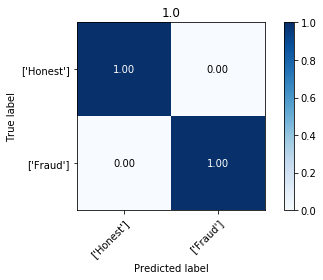

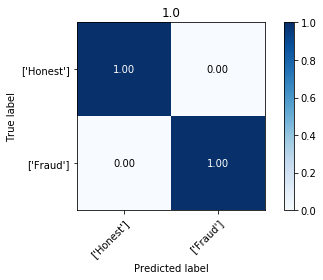

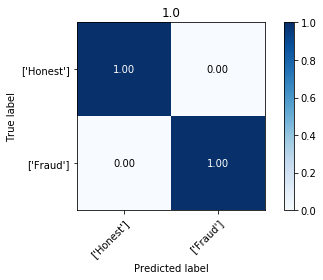

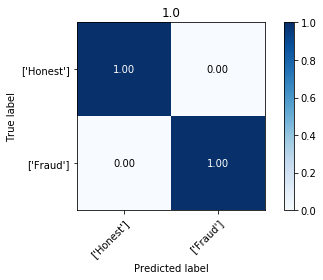

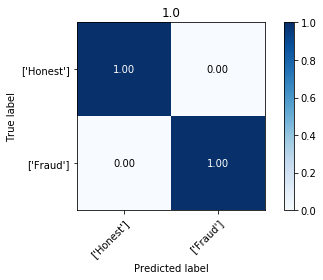

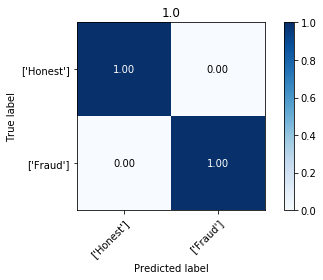

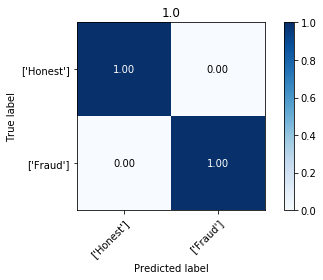

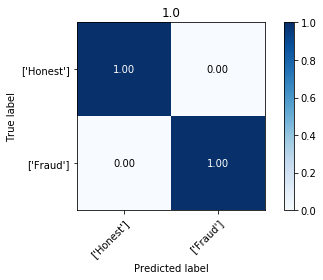

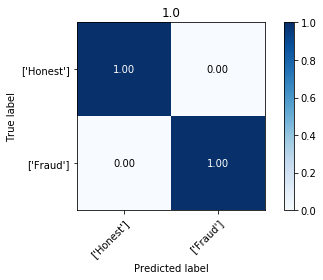

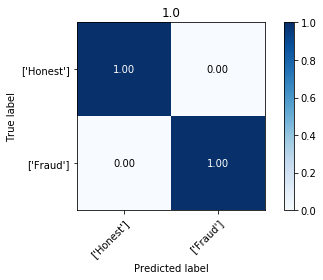

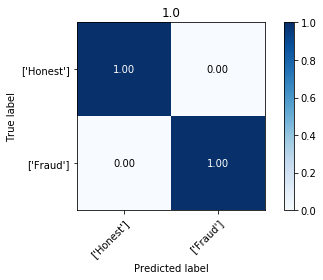

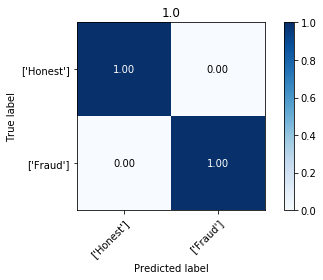

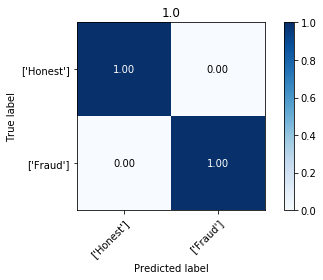

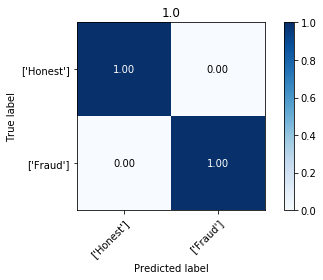

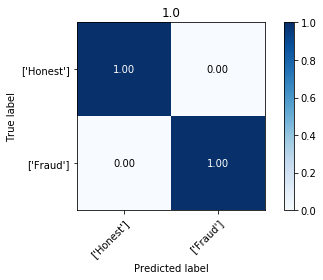

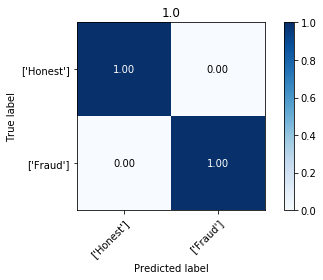

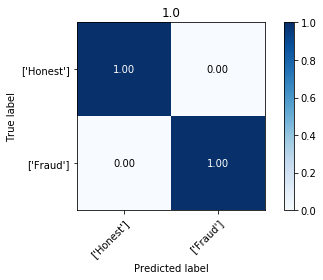

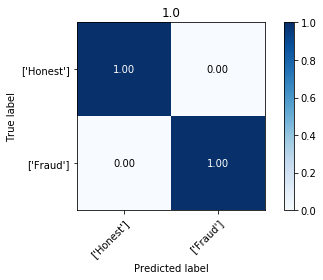

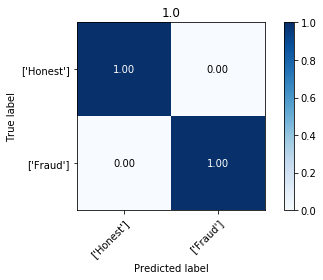

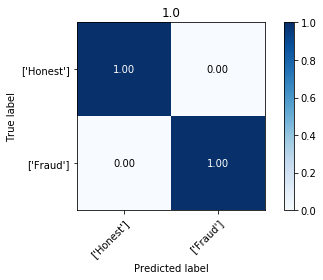

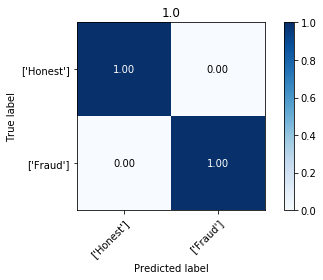

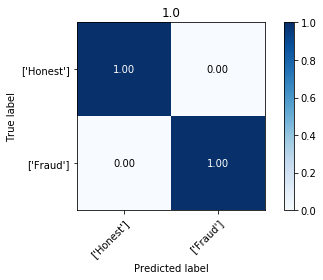

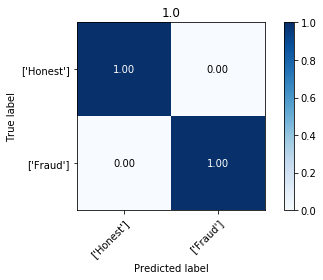

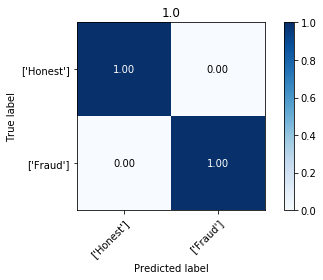

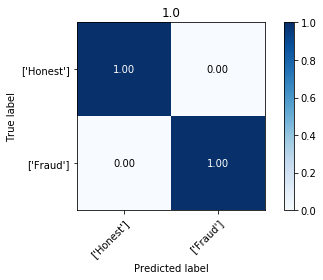

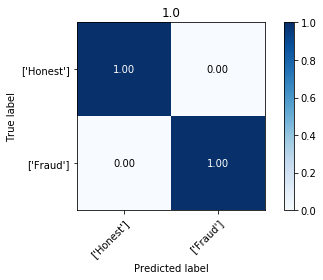

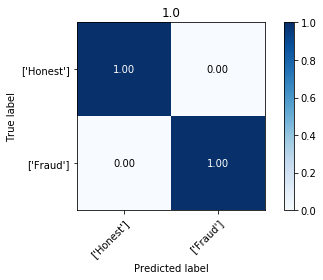

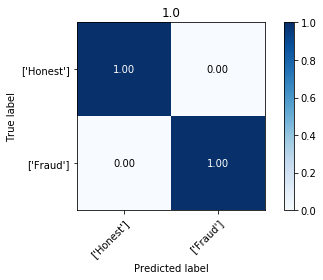

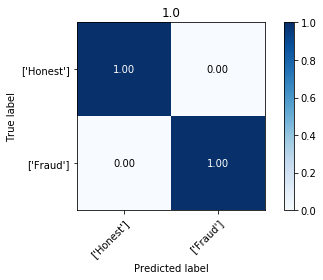

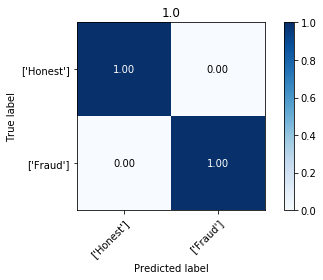

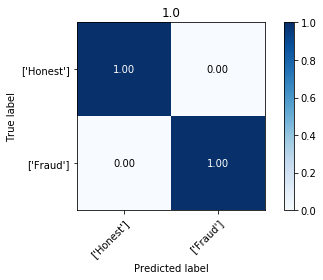

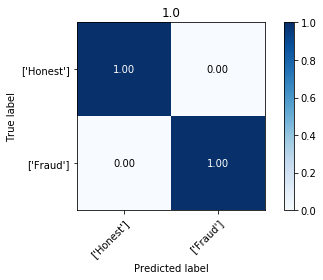

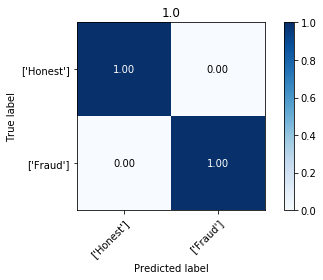

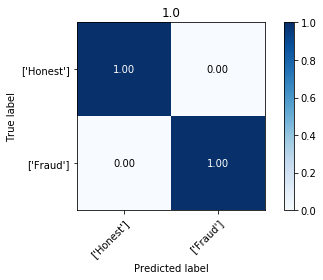

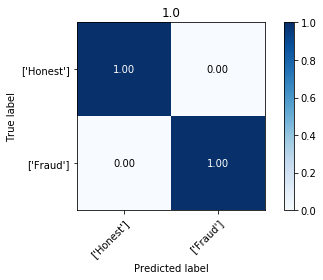

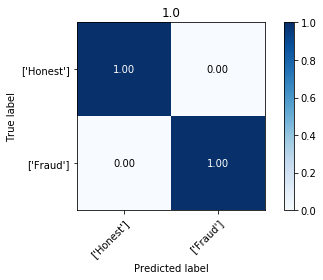

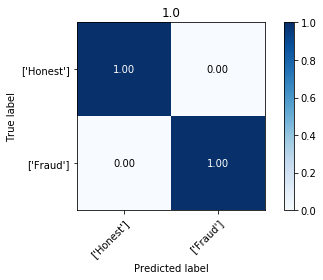

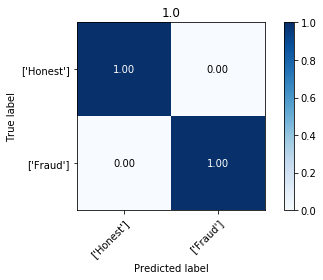

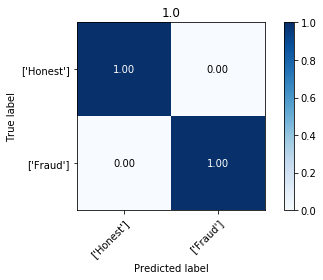

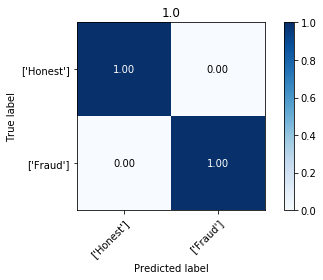

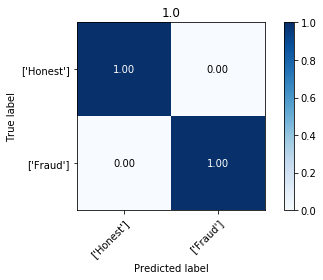

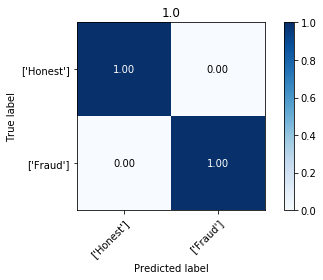

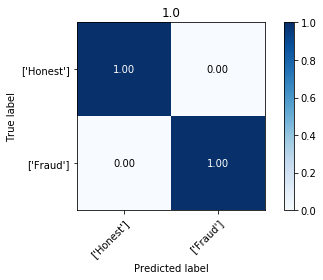

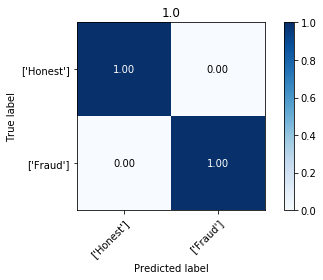

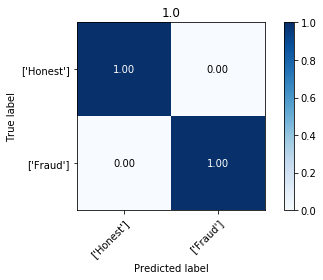

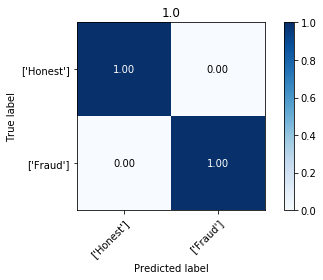

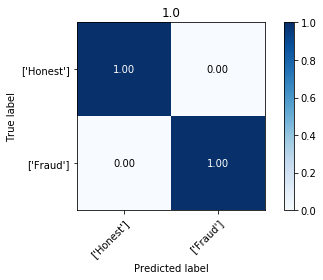

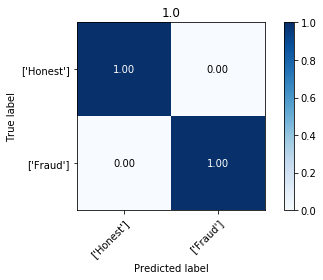

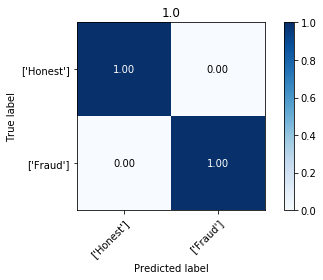

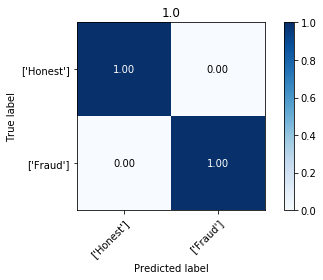

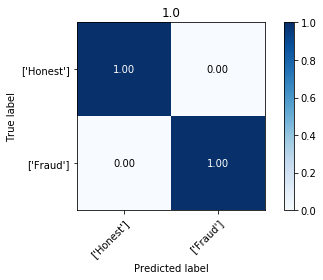

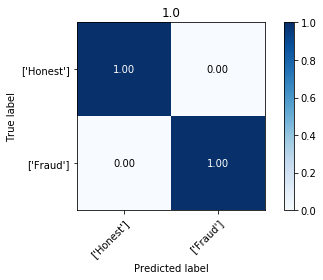

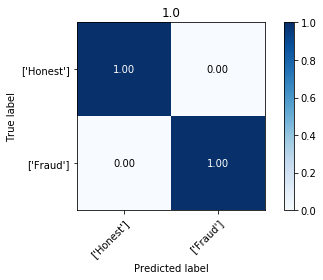

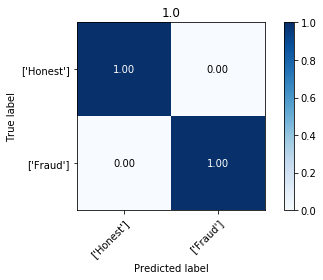

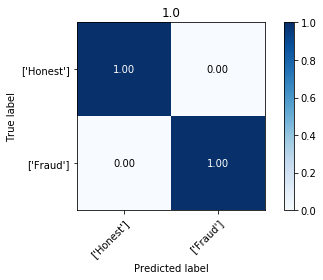

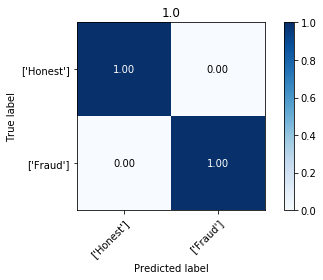

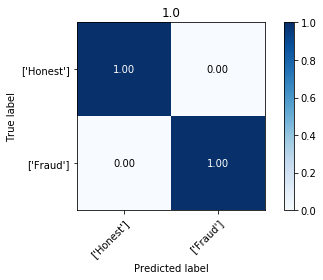

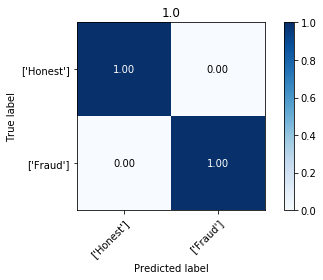

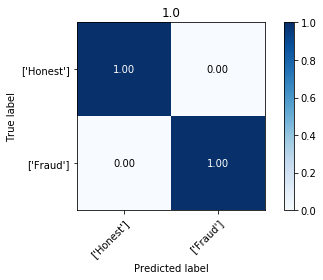

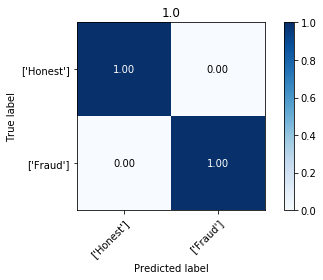

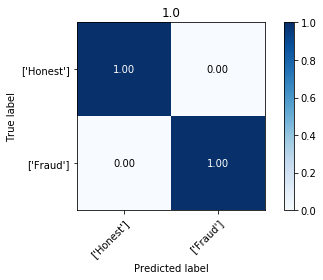

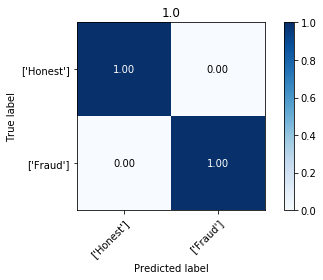

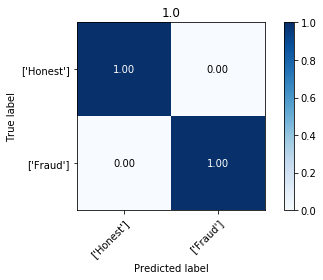

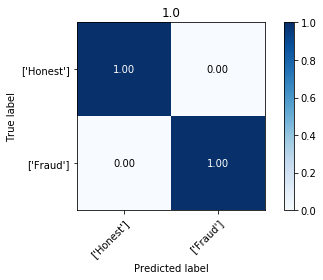

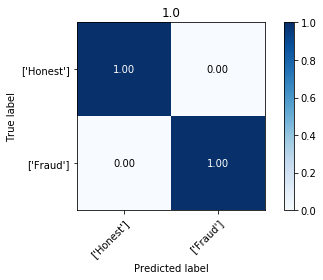

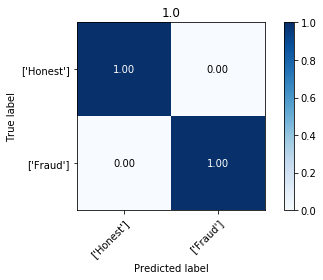

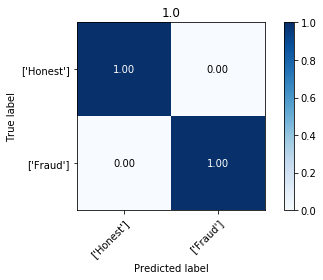

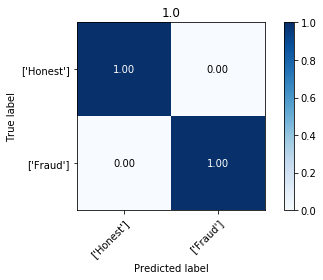

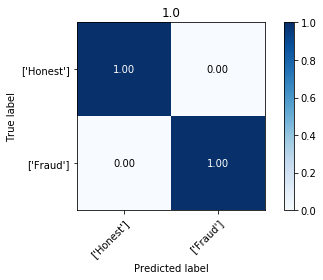

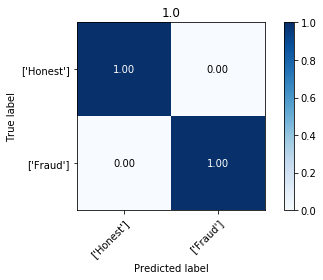

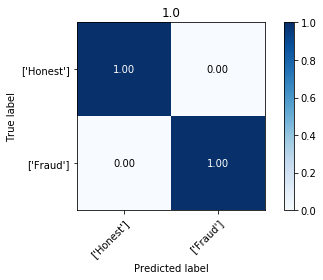

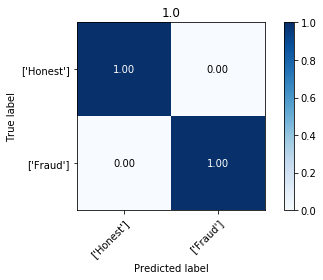

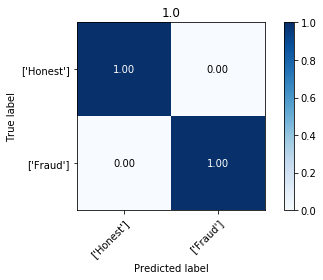

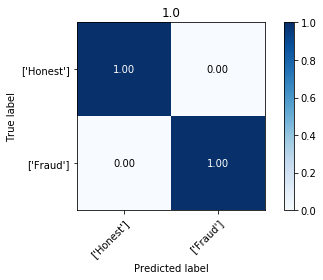

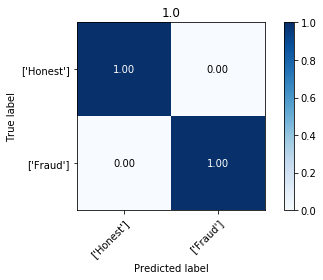

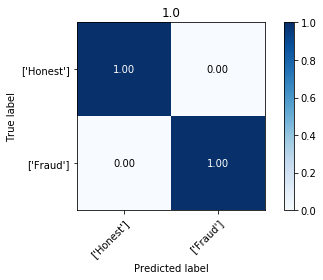

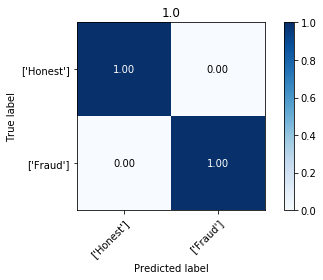

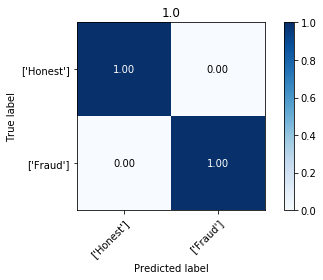

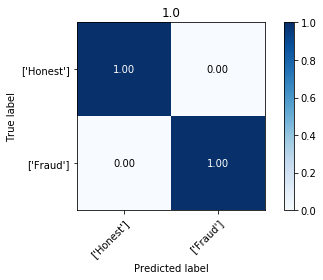

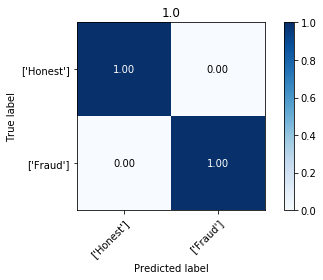

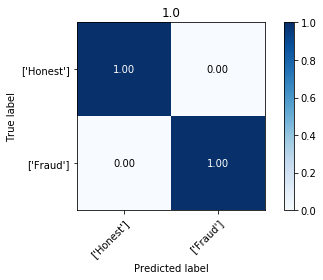

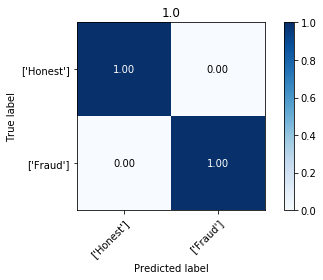

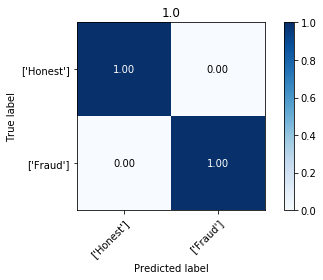

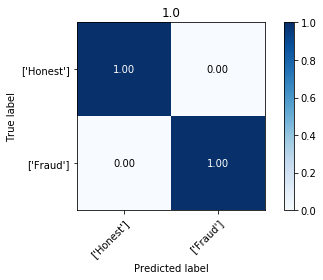

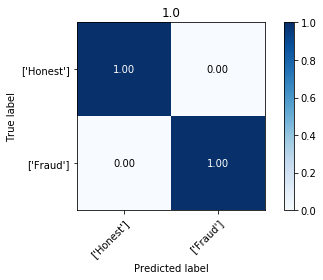

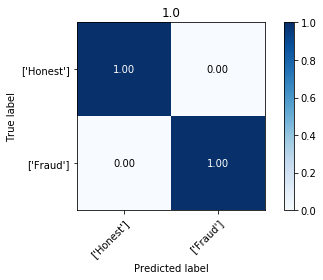

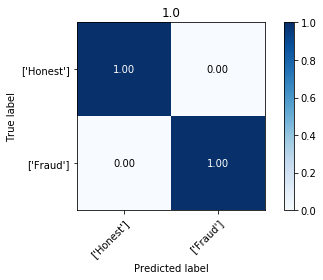

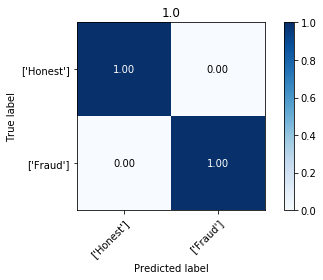

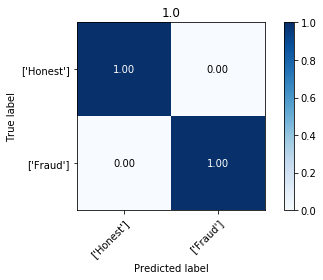

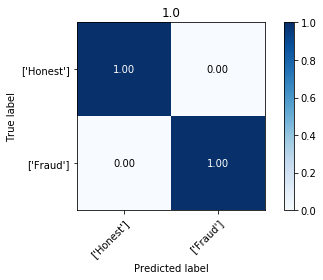

In [86]:
prob = np.ravel(model.predict_proba(x_data[0])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

### As we can see, the LGBMClassifier overfitted data. To choose the threshold we will use the val data.

precision values: [0.7133800467133801, 0.7155839784584315, 0.7187606401089547, 0.7220315717227179, 0.7226832641770401, 0.7252362618130906, 0.7277856135401974, 0.7295285359801489, 0.7306457367106671, 0.7314449623520975, 0.7328767123287672, 0.7331887201735358, 0.7368037859483072, 0.7380952380952381, 0.7404270986745214, 0.7408502772643253, 0.7421033073206986, 0.7440209267563528, 0.7447447447447447, 0.7453860640301319, 0.7470699432892249, 0.7493353589061906, 0.7508597630875048, 0.7529773338455628, 0.7553150367220719, 0.7566938300349243, 0.7575875486381323, 0.7604696673189824, 0.7618860510805501, 0.7634281200631912, 0.7634920634920634, 0.7640047675804529, 0.7661870503597122, 0.7664790996784566, 0.7699150828952689, 0.7700729927007299, 0.7714867617107943, 0.7720377203772038, 0.7737948084054388, 0.7750206782464847, 0.7750621375310688, 0.776255707762557, 0.7772689425478768, 0.7788944723618091, 0.779554059739167, 0.780261493040911, 0.7802197802197802, 0.7804154302670623, 0.7805189281156955, 0.78

Normalized confusion matrix
[[0.9190146  0.0809854 ]
 [0.37022133 0.62977867]]
Normalized confusion matrix
[[0.91975218 0.08024782]
 [0.37156271 0.62843729]]
Normalized confusion matrix
[[0.91989969 0.08010031]
 [0.37256875 0.62743125]]
Normalized confusion matrix
[[0.92048975 0.07951025]
 [0.37290409 0.62709591]]
Normalized confusion matrix
[[0.92107981 0.07892019]
 [0.37391013 0.62608987]]
Normalized confusion matrix
[[0.92211241 0.07788759]
 [0.37625755 0.62374245]]
Normalized confusion matrix
[[0.92270246 0.07729754]
 [0.37860496 0.62139504]]
Normalized confusion matrix
[[0.92314501 0.07685499]
 [0.379611   0.620389  ]]
Normalized confusion matrix
[[0.92329252 0.07670748]
 [0.38095238 0.61904762]]
Normalized confusion matrix
[[0.92358755 0.07641245]
 [0.38262911 0.61737089]]
Normalized confusion matrix
[[0.92388258 0.07611742]
 [0.38464118 0.61535882]]
Normalized confusion matrix
[[0.92432512 0.07567488]
 [0.38732394 0.61267606]]
Normalized confusion matrix
[[0.92462015 0.07537985]

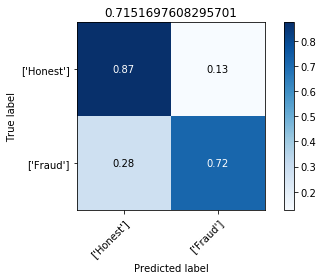

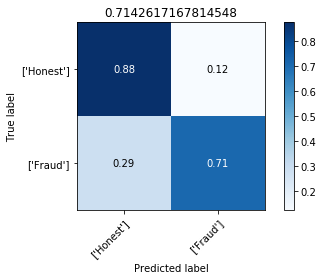

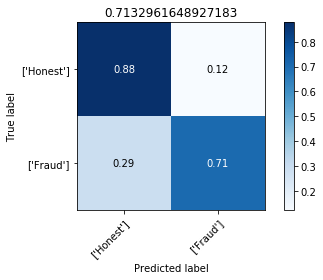

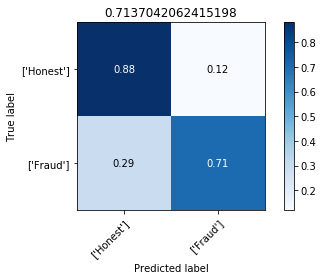

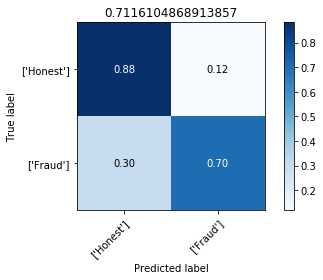

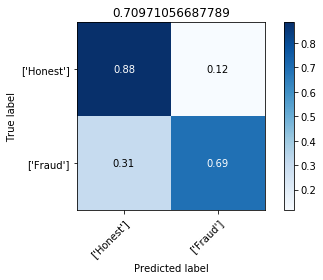

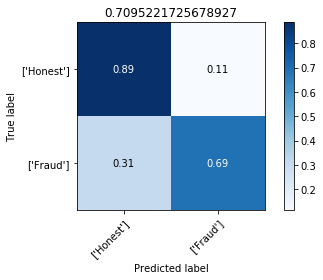

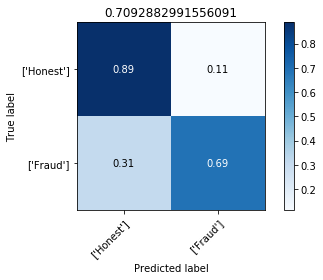

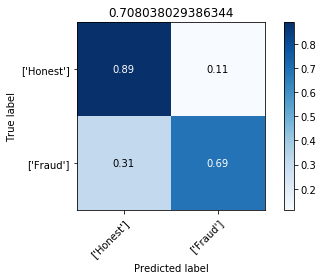

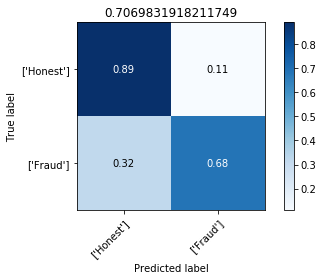

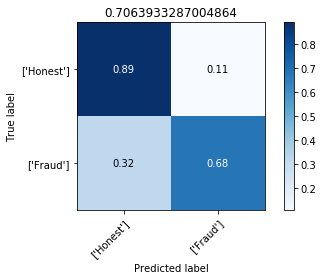

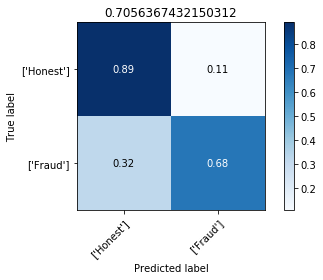

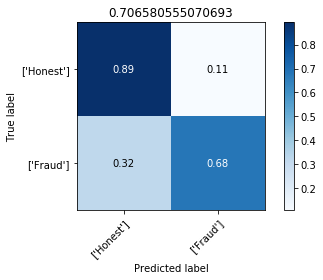

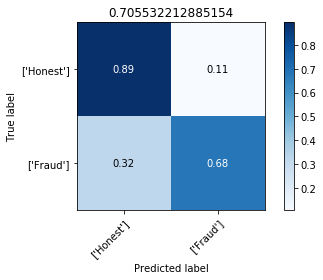

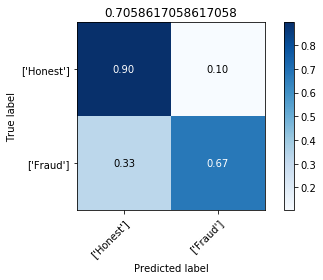

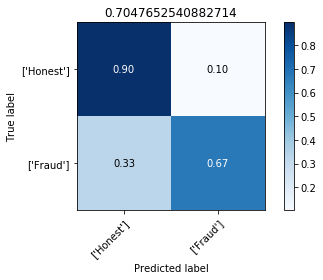

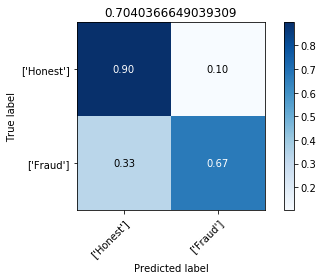

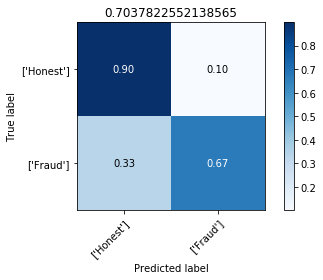

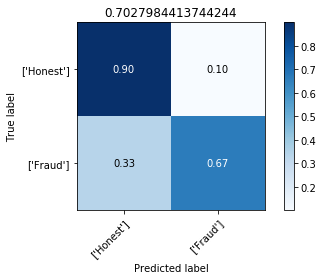

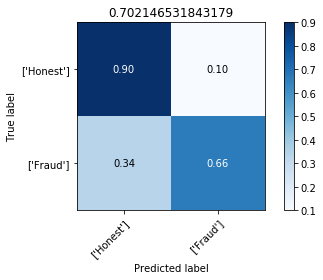

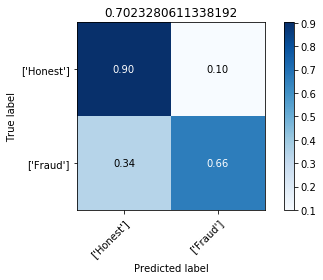

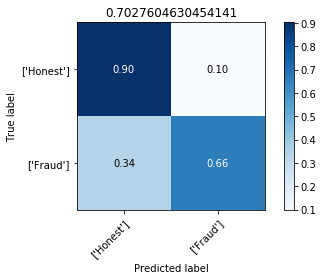

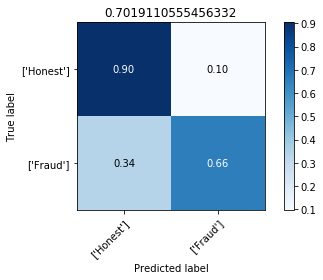

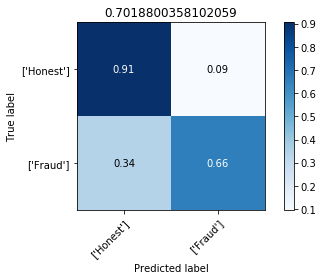

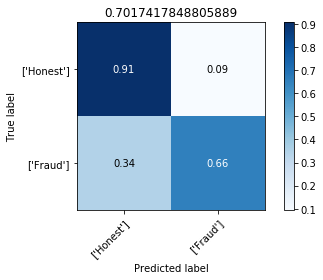

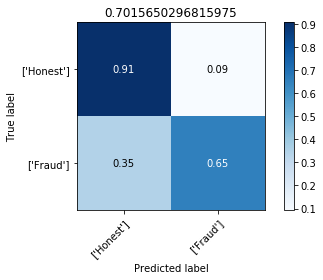

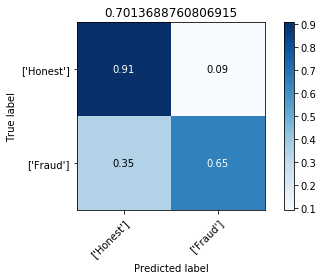

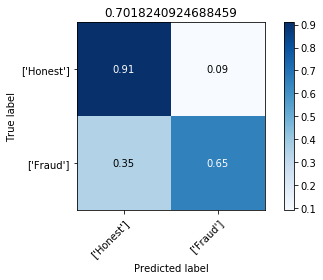

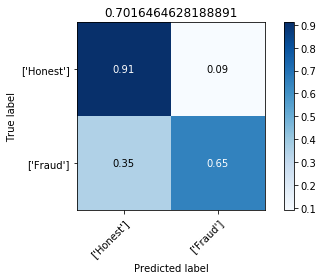

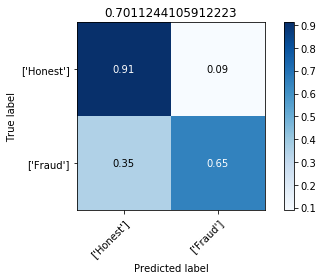

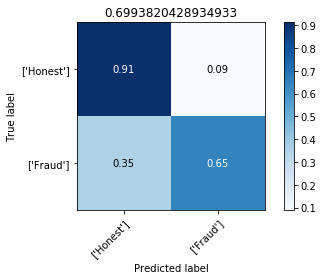

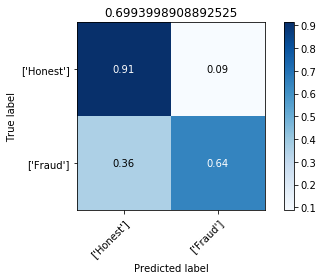

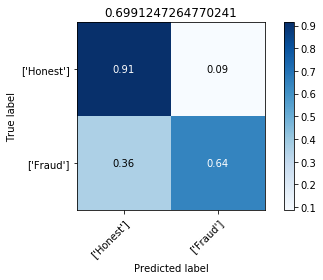

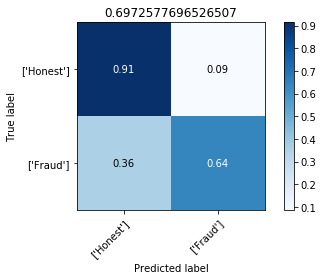

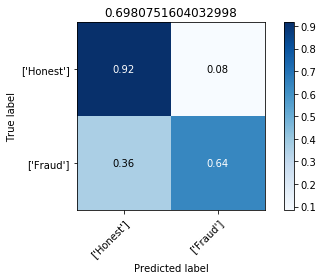

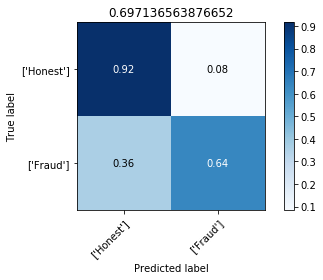

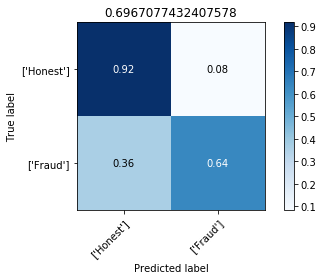

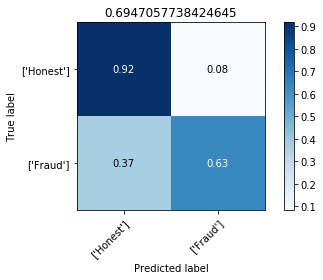

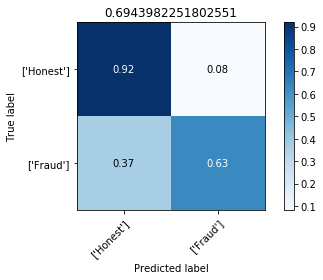

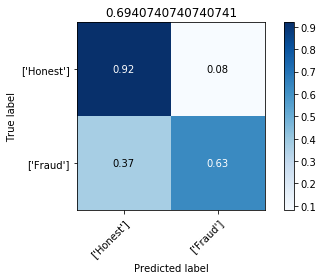

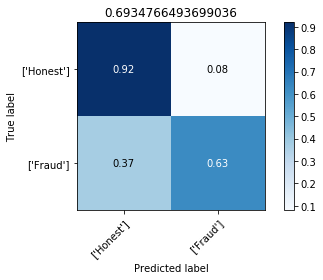

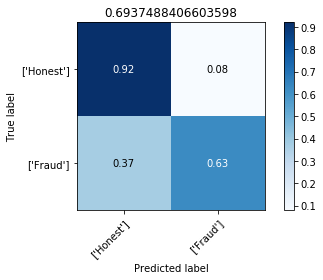

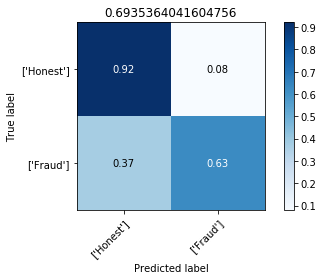

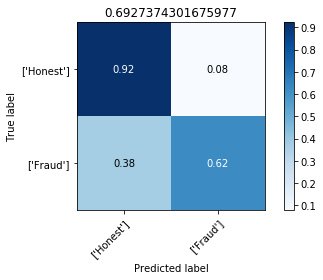

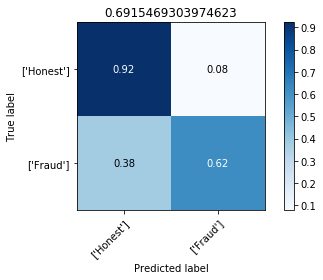

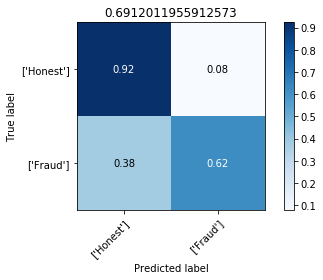

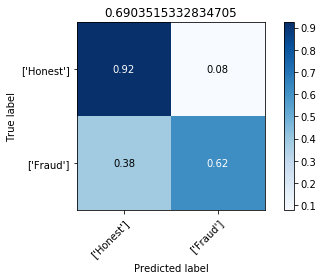

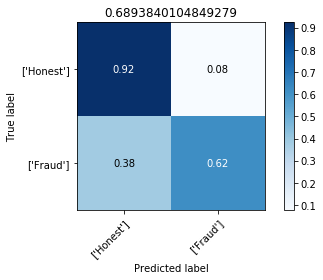

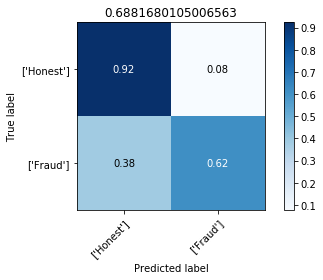

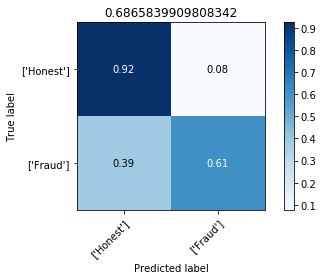

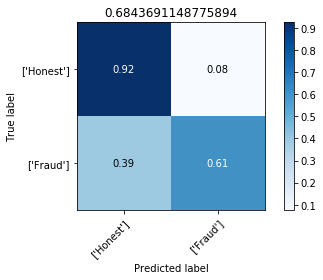

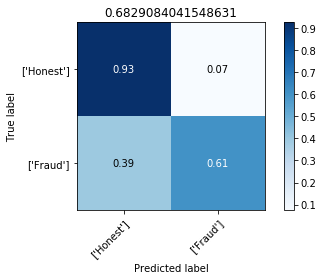

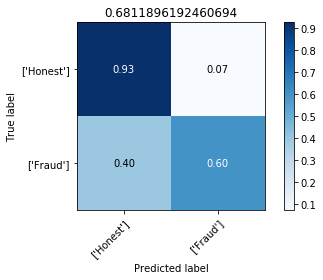

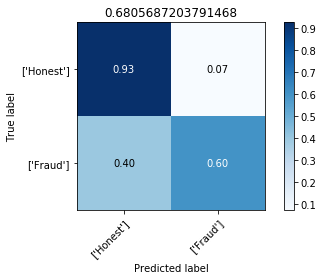

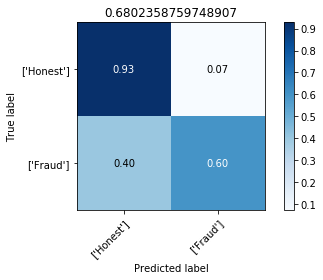

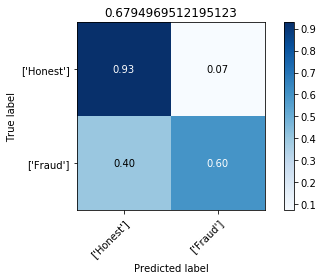

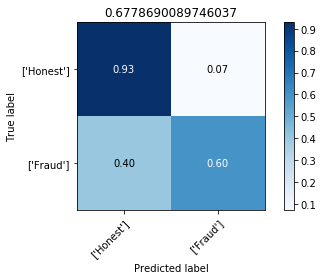

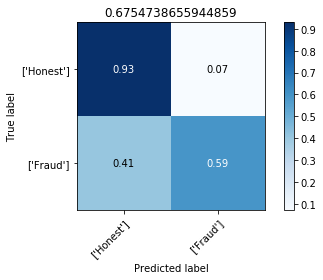

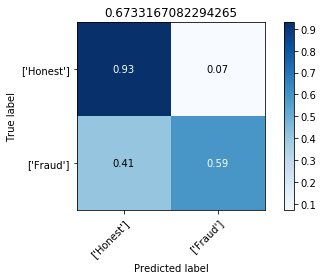

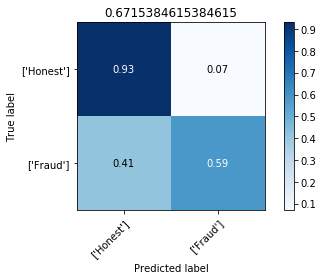

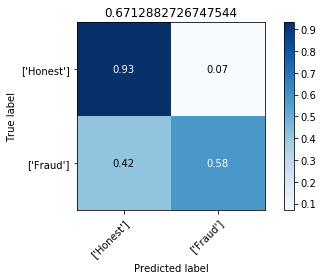

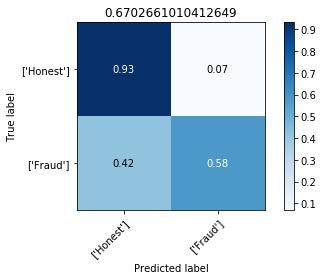

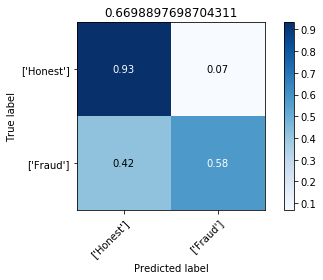

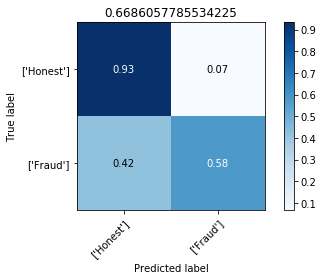

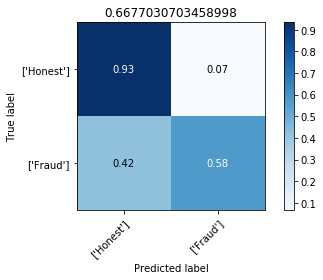

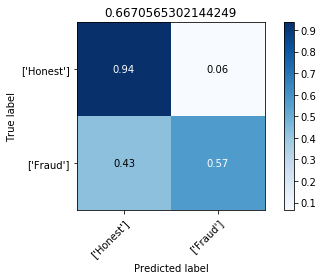

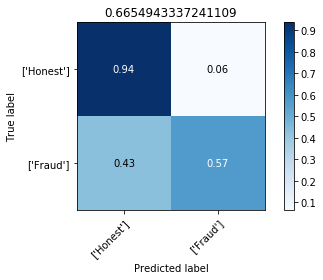

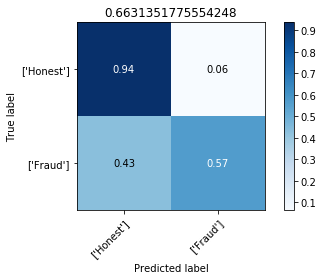

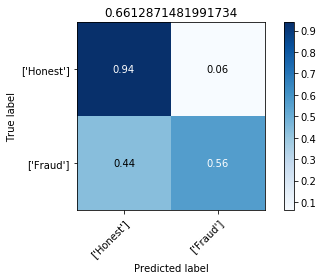

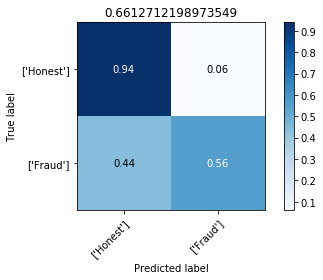

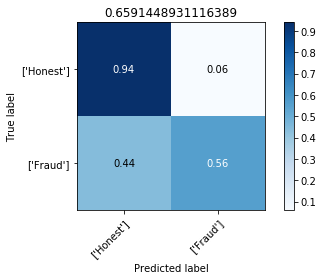

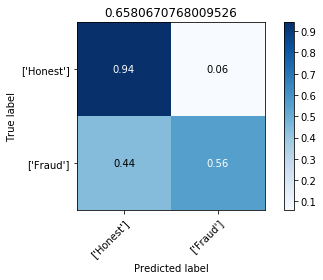

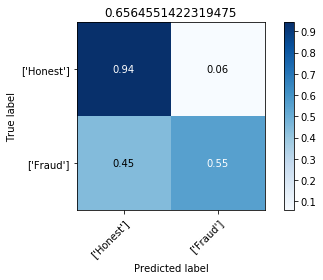

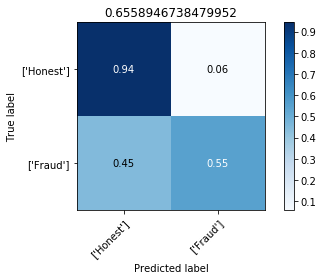

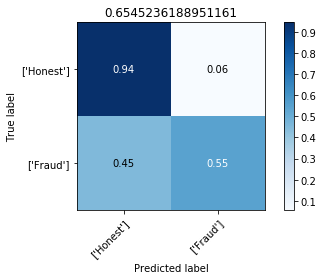

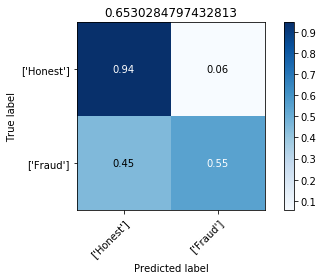

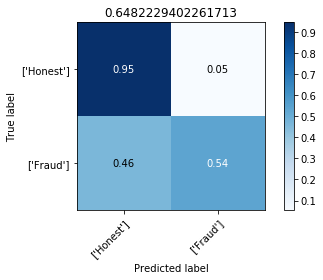

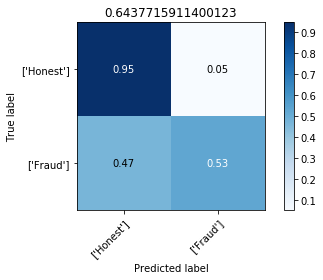

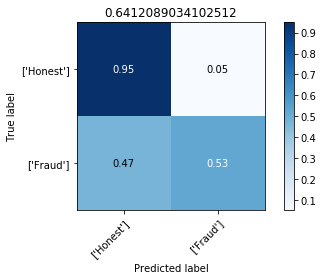

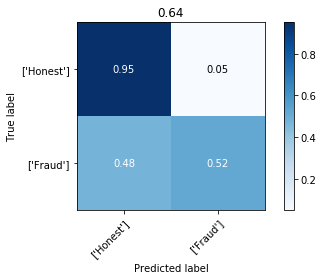

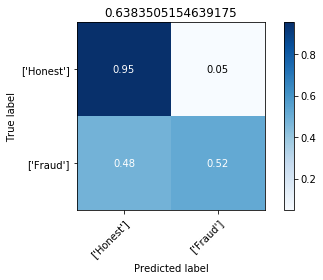

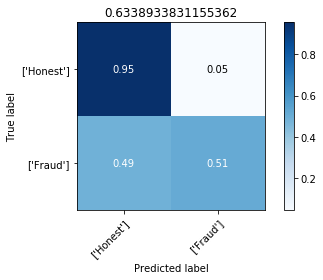

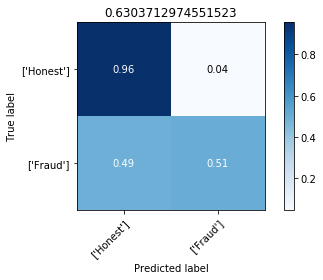

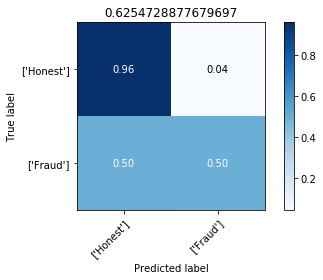

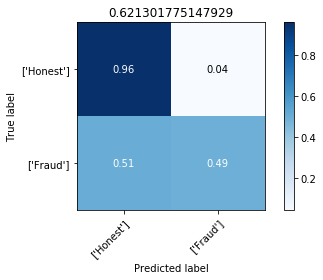

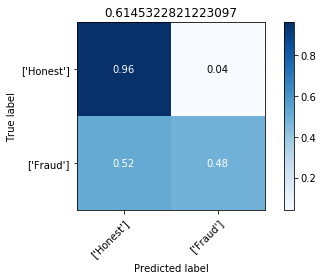

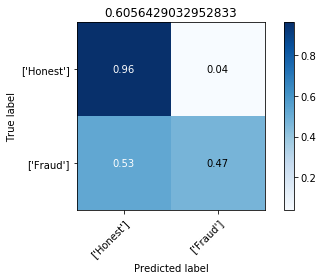

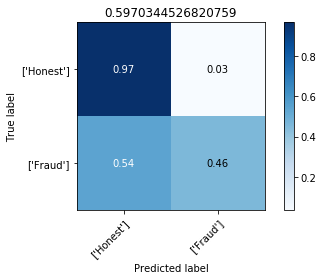

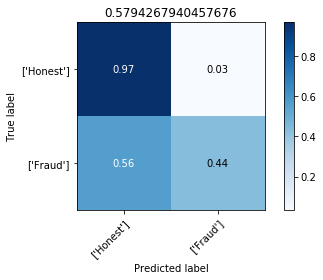

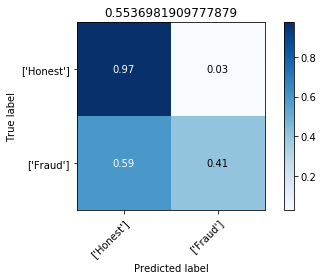

In [87]:
prob = np.ravel(model.predict_proba(x_data[1])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

- ### Predicting with the best Threshold

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[0.87328515 0.12671485]
 [0.28303152 0.71696848]]
Normalized confusion matrix
[[0.87691627 0.12308373]
 [0.28485052 0.71514948]]


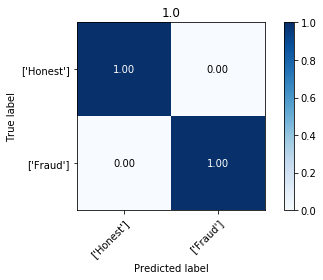

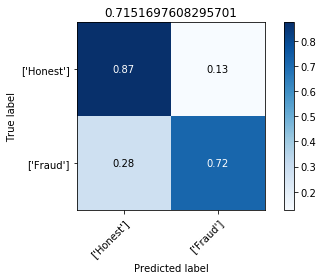

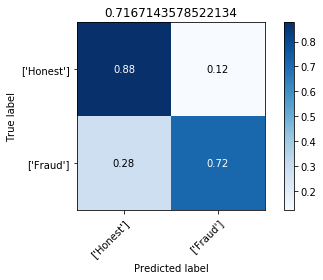

In [88]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])[:,1]),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

# XGBoostClassifier

In [91]:
model = XGBClassifier(n_estimators=8000)
model.fit(x_data[0],y_data[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=8000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [92]:
model.save_model(path+'/Undersampling/Boost/models/XGBoostClassifier')

- ###  Analysing the performance with differents thresholds

precision values: [0.9389693186346129, 0.9576024381984423, 0.971685794790736, 0.9820795999166493, 0.9883265762617084, 0.9920712882402469, 0.9957743503063596, 0.9977418671935643, 0.9985874708665866, 0.9995051604693906, 0.9996464932126696, 0.9997878659312686, 0.9998585672866134, 0.99992927864215, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999292736402857, 0.9999292736402857, 0.9999292736402857, 0.9998585472805714, 0.9997878209208572, 0.999646

Normalized confusion matrix
[[1.         0.        ]
 [0.02404696 0.97595304]]
Normalized confusion matrix
[[1.         0.        ]
 [0.02956362 0.97043638]]
Normalized confusion matrix
[[1.        0.       ]
 [0.0362119 0.9637881]]
Normalized confusion matrix
[[1.         0.        ]
 [0.04356744 0.95643256]]
Normalized confusion matrix
[[1.         0.        ]
 [0.05254969 0.94745031]]
Normalized confusion matrix
[[1.         0.        ]
 [0.06209774 0.93790226]]
Normalized confusion matrix
[[1.        0.       ]
 [0.0743334 0.9256666]]
Normalized confusion matrix
[[1.         0.        ]
 [0.08968102 0.91031898]]
Normalized confusion matrix
[[1.         0.        ]
 [0.10856496 0.89143504]]
Normalized confusion matrix
[[1.         0.        ]
 [0.12949996 0.87050004]]
Normalized confusion matrix
[[1.        0.       ]
 [0.1558809 0.8441191]]
Normalized confusion matrix
[[1.         0.        ]
 [0.18452507 0.81547493]]
Normalized confusion matrix
[[1.         0.        ]
 [0.2158568

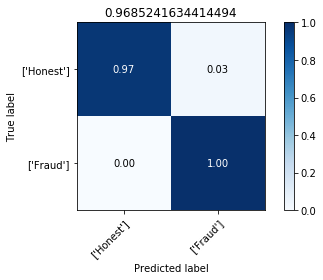

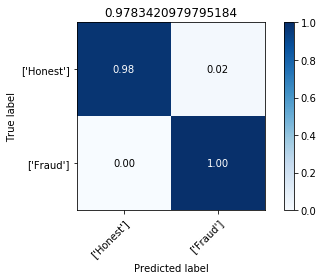

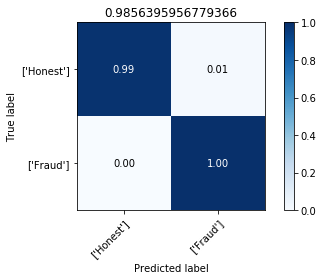

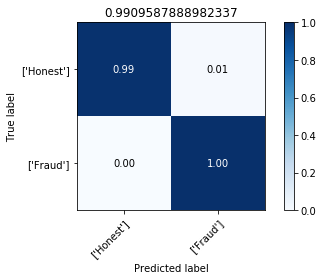

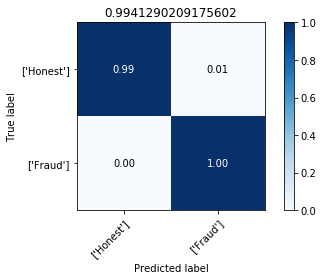

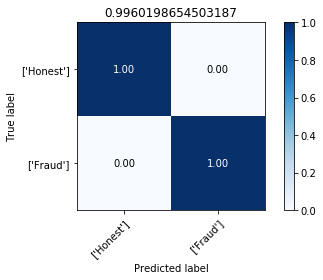

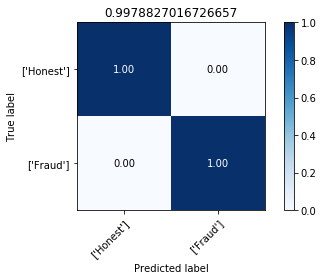

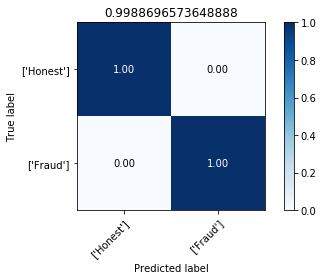

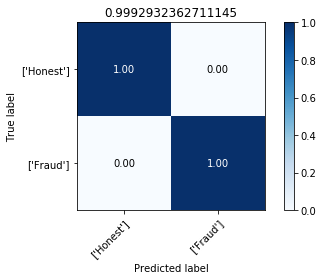

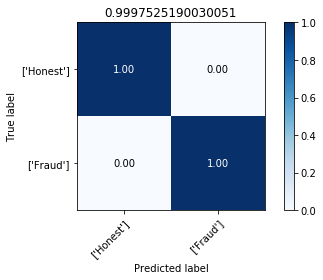

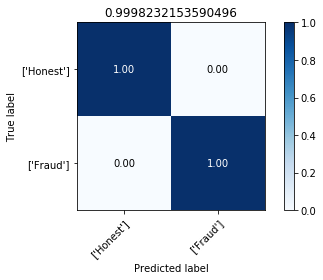

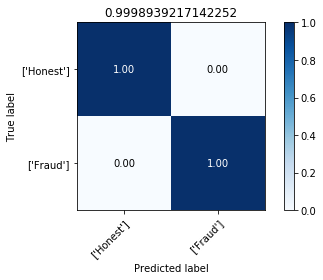

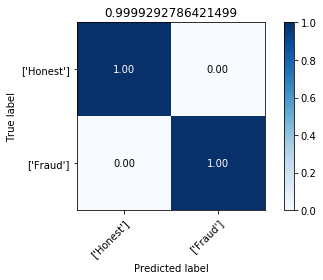

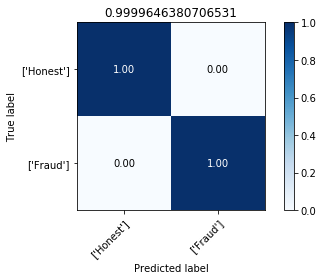

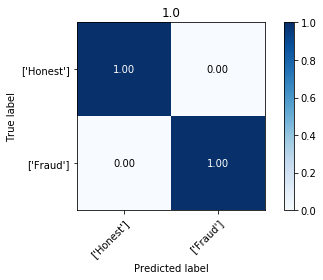

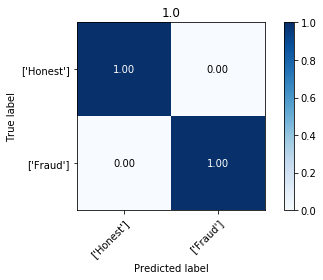

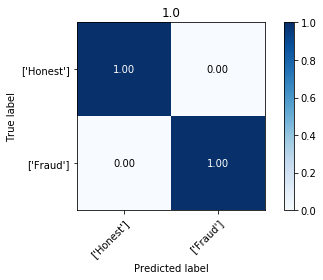

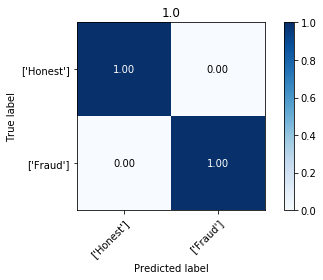

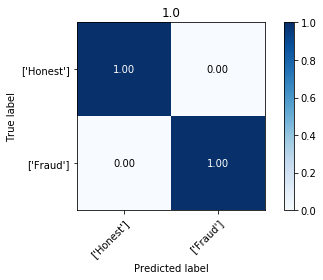

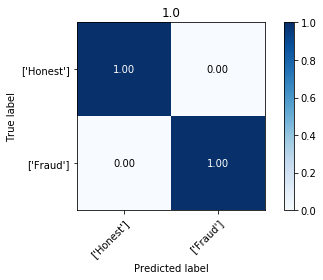

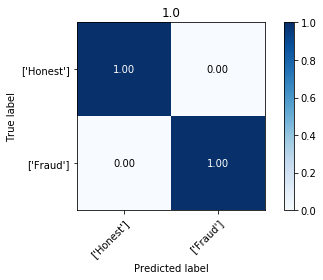

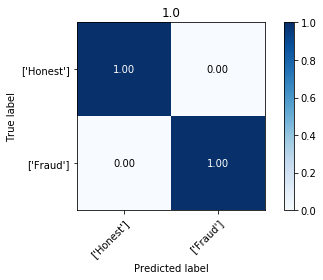

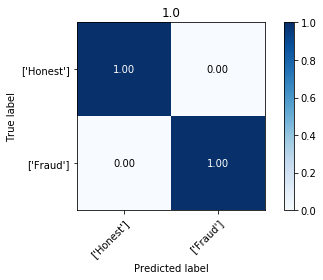

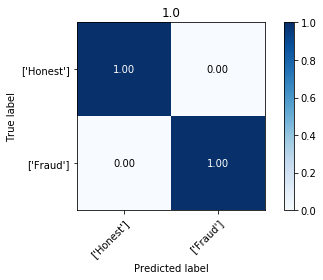

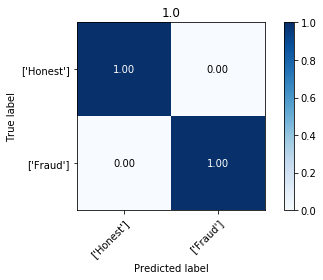

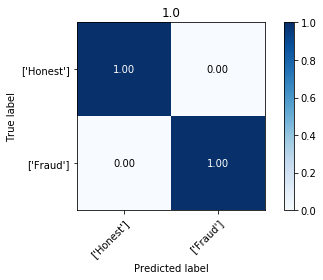

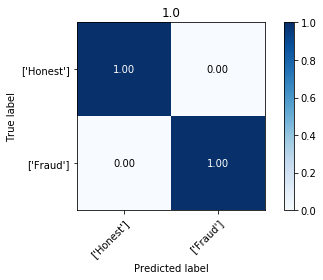

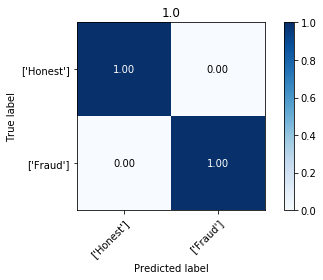

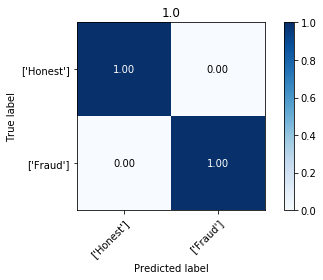

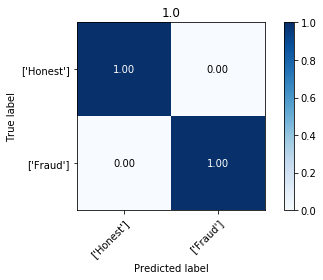

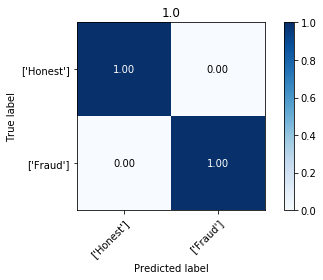

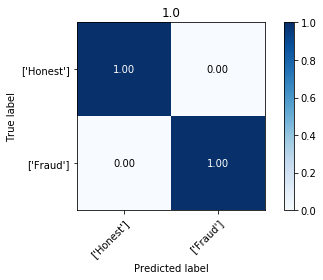

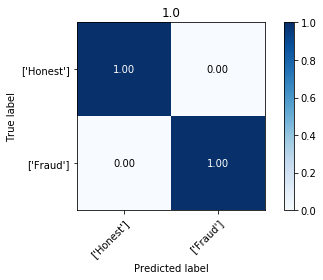

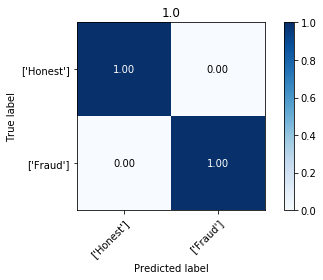

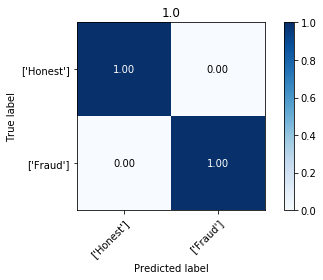

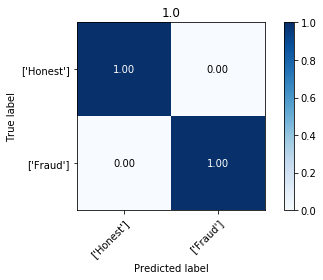

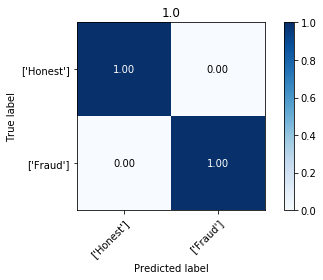

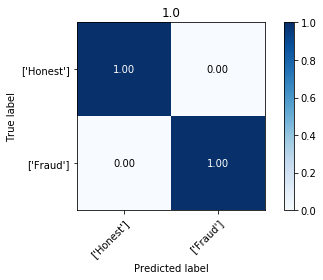

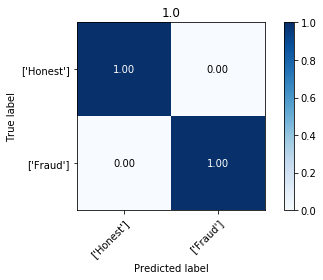

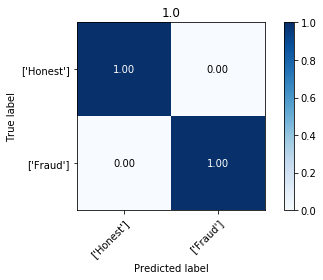

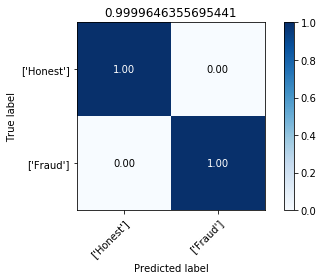

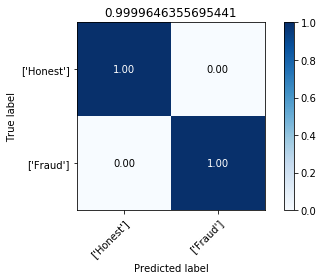

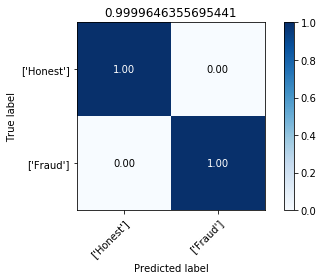

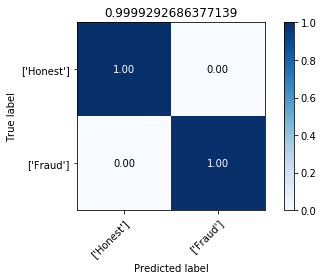

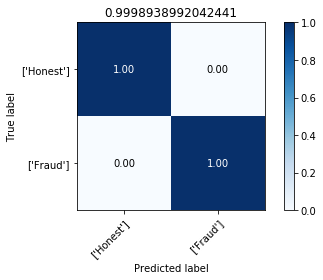

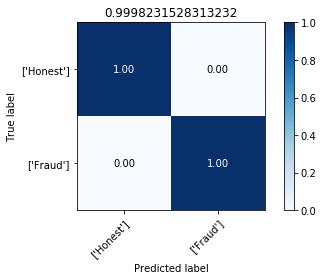

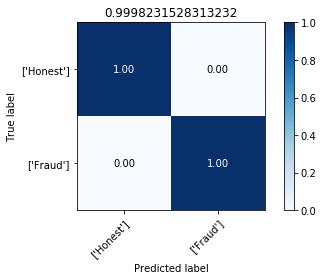

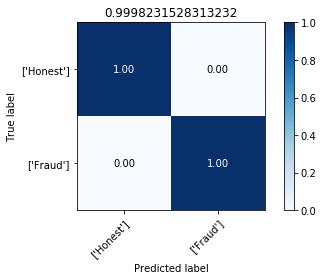

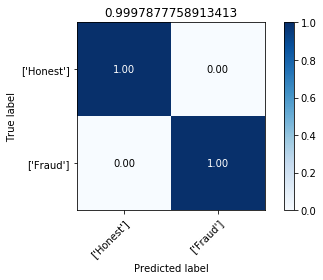

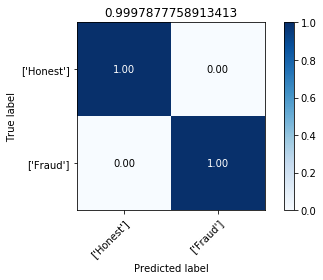

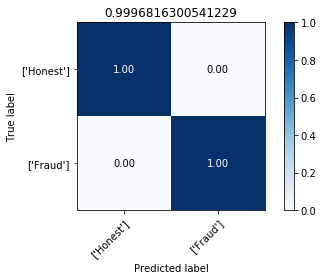

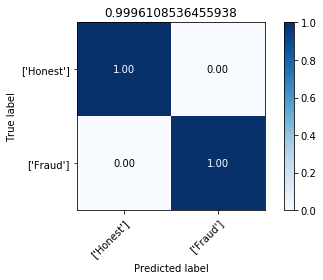

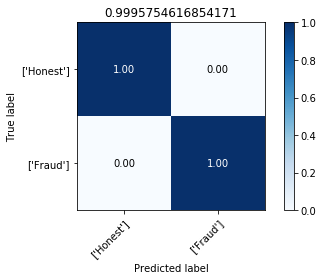

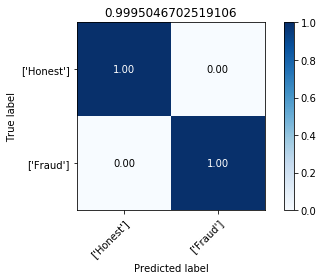

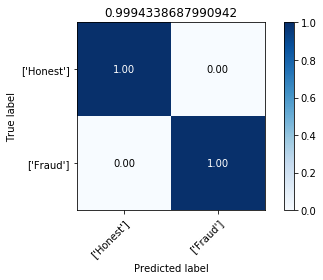

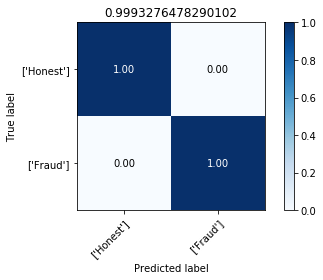

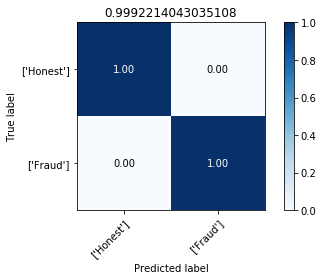

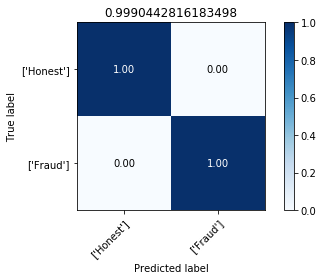

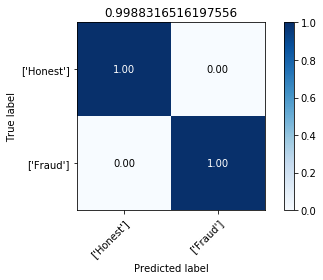

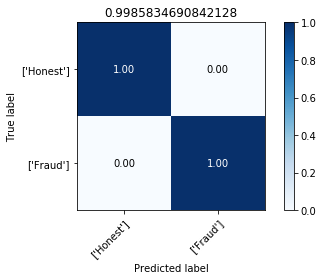

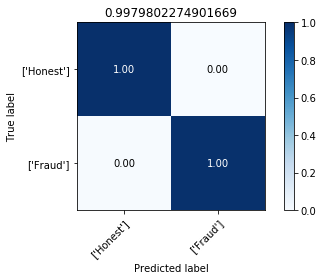

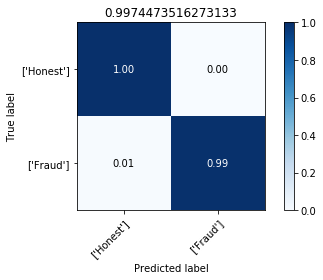

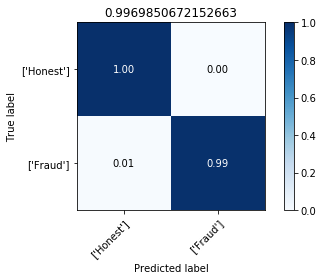

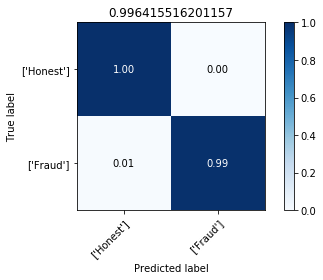

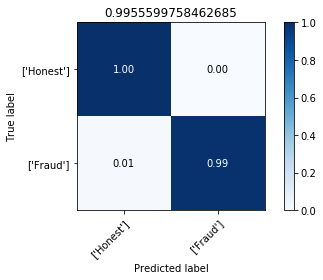

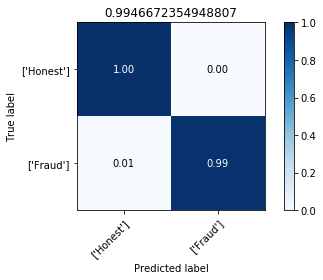

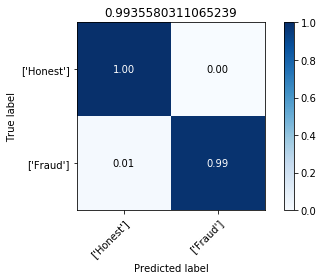

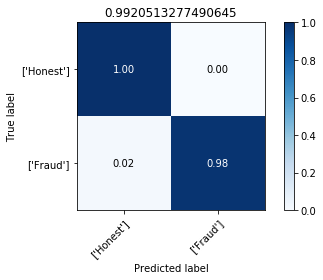

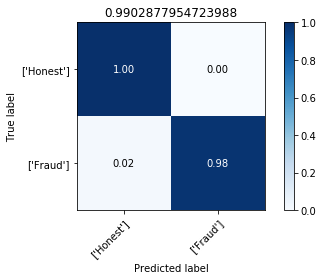

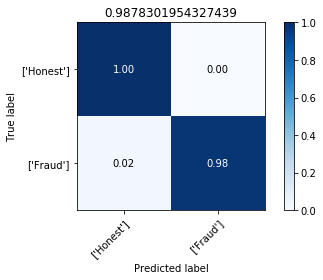

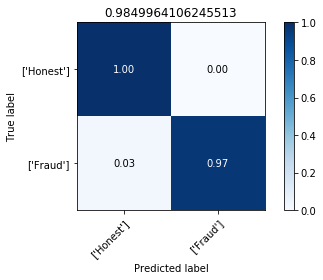

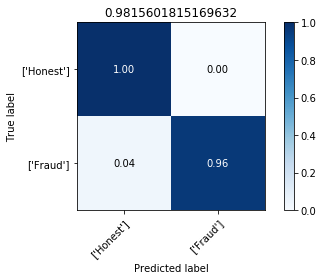

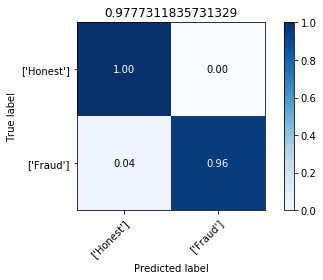

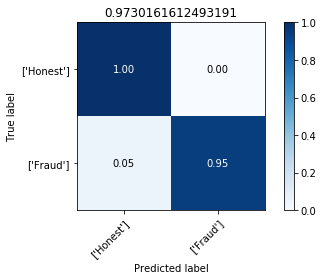

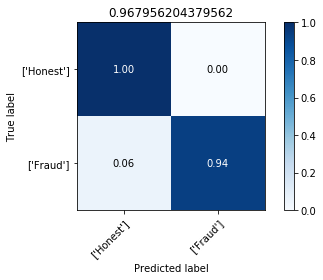

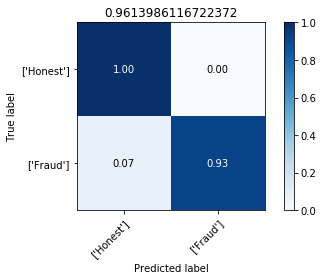

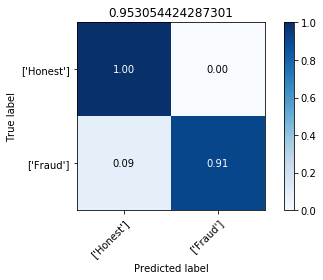

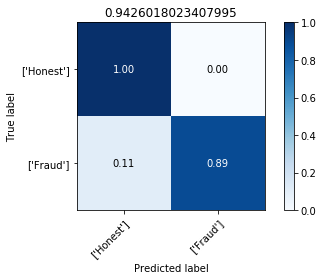

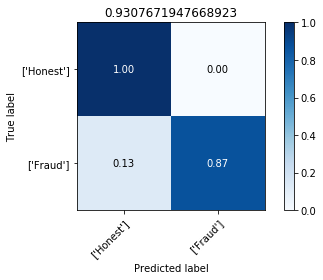

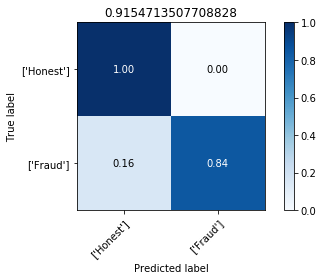

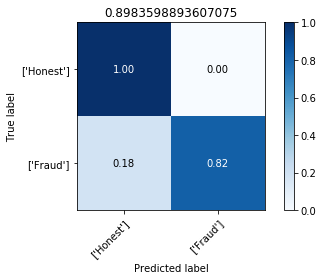

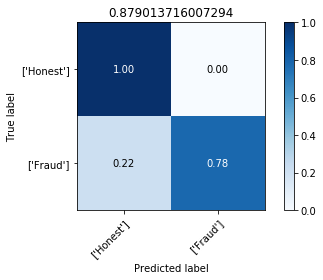

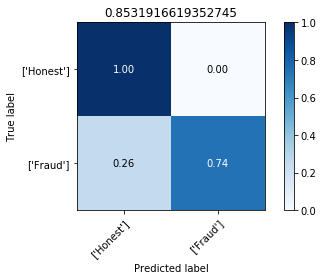

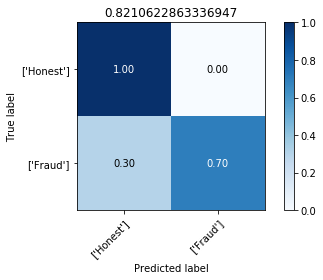

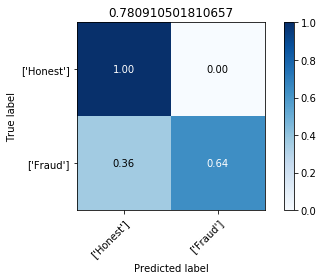

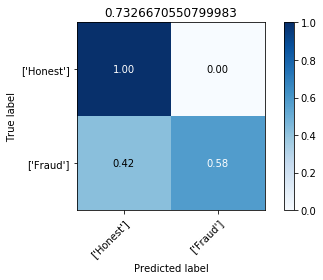

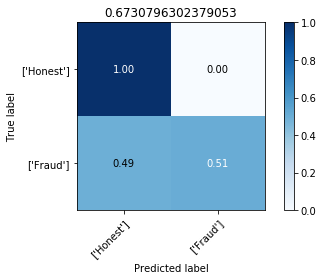

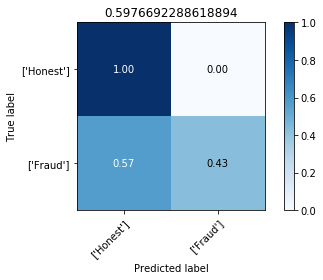

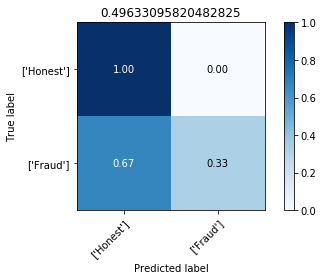

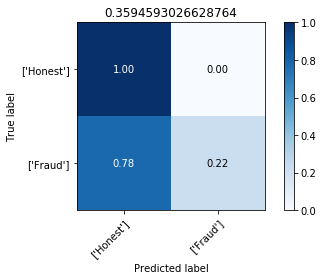

In [96]:
prob = np.ravel(model.predict_proba(x_data[0])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

### As we can see, the XGBoostClassifier overfitted data. To choose the threshold we will use the val data.

precision values: [0.5602240896358543, 0.5709549071618037, 0.5800316957210776, 0.5865495724520453, 0.5943708609271523, 0.6014492753623188, 0.6085777668227754, 0.6145181476846058, 0.6215596330275229, 0.6269042086238058, 0.6323914181057039, 0.6364602710603242, 0.643107634205557, 0.6476556073485056, 0.6519198664440734, 0.6552112676056338, 0.6594161419576416, 0.6616454229432214, 0.6656874265569918, 0.6701399225960107, 0.6741233373639661, 0.6788231688630095, 0.6838349363946633, 0.6875784190715182, 0.6921119592875318, 0.6949644932214332, 0.6979405034324943, 0.6997026759167493, 0.7002679169457469, 0.7032410533423362, 0.7079343365253078, 0.7115185057073677, 0.7147346368715084, 0.7177675732956552, 0.7223411848679515, 0.7253342970726419, 0.7285974499089253, 0.7318332718554039, 0.7345495160089353, 0.7371385655276005, 0.7398404861374858, 0.7425287356321839, 0.7455598455598456, 0.7485380116959064, 0.7513790386130812, 0.7548824232762057, 0.7561665992721391, 0.7587197373820271, 0.7614487926727727, 0.

Normalized confusion matrix
[[0.89275704 0.10724296]
 [0.33467471 0.66532529]]
Normalized confusion matrix
[[0.89482225 0.10517775]
 [0.33836351 0.66163649]]
Normalized confusion matrix
[[0.89673993 0.10326007]
 [0.34171697 0.65828303]]
Normalized confusion matrix
[[0.89895265 0.10104735]
 [0.34674715 0.65325285]]
Normalized confusion matrix
[[0.90087033 0.09912967]
 [0.3501006  0.6498994 ]]
Normalized confusion matrix
[[0.90278802 0.09721198]
 [0.35244802 0.64755198]]
Normalized confusion matrix
[[0.90485322 0.09514678]
 [0.35613682 0.64386318]]
Normalized confusion matrix
[[0.90691842 0.09308158]
 [0.36049631 0.63950369]]
Normalized confusion matrix
[[0.90927865 0.09072135]
 [0.3648558  0.6351442 ]]
Normalized confusion matrix
[[0.91104883 0.08895117]
 [0.37290409 0.62709591]]
Normalized confusion matrix
[[0.91326154 0.08673846]
 [0.37994634 0.62005366]]
Normalized confusion matrix
[[0.91547426 0.08452574]
 [0.38665325 0.61334675]]
Normalized confusion matrix
[[0.91709692 0.08290308]

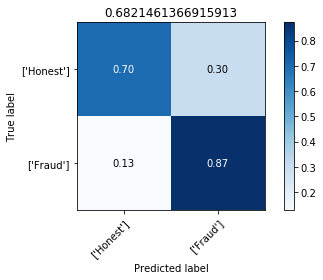

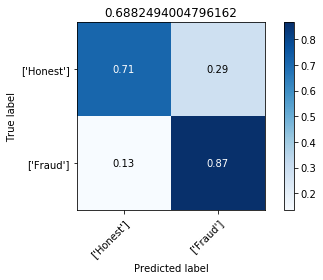

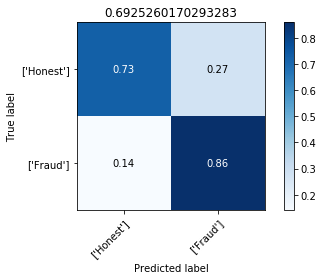

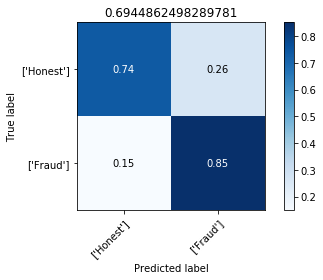

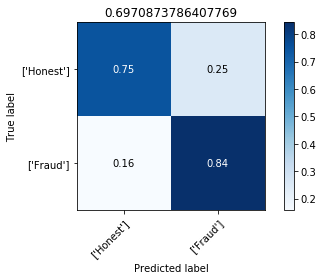

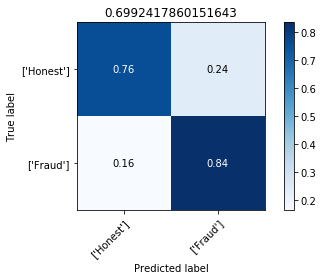

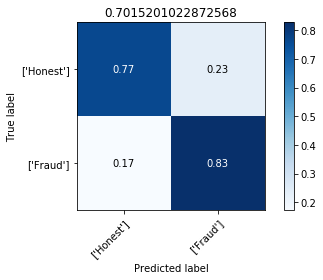

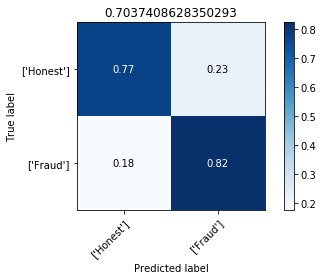

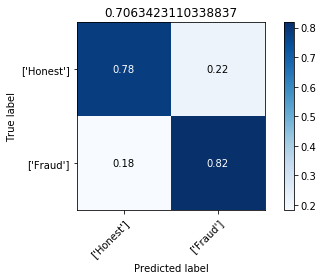

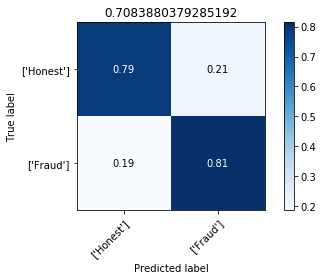

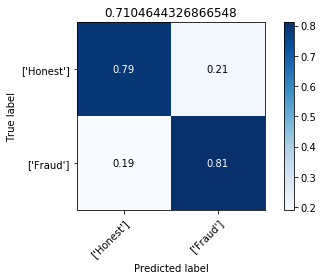

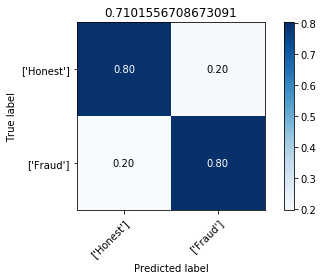

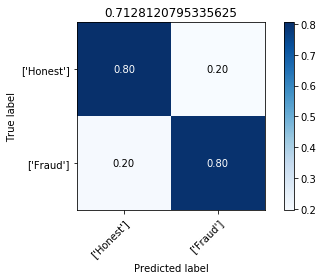

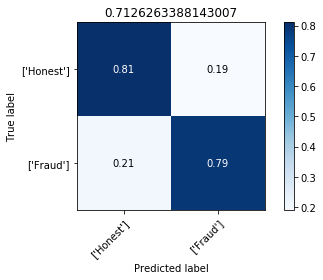

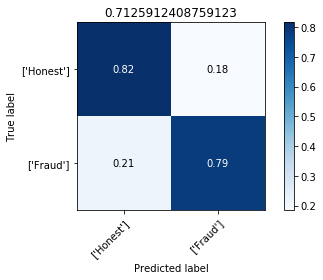

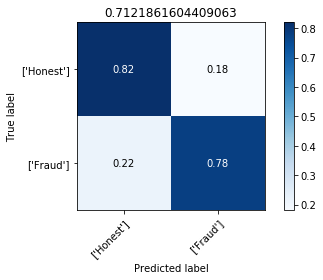

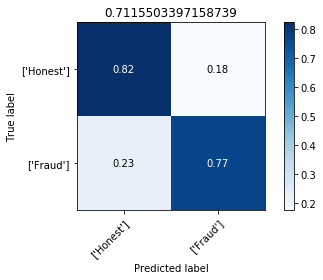

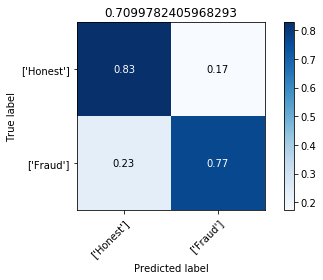

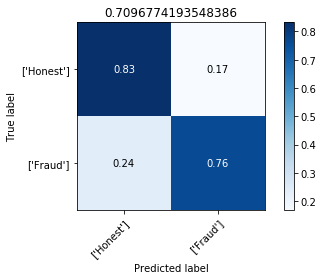

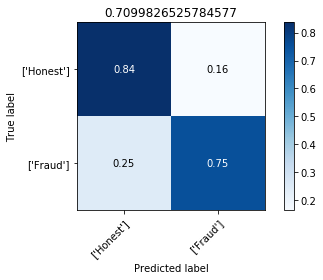

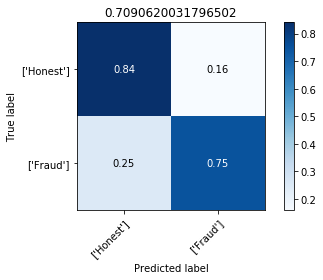

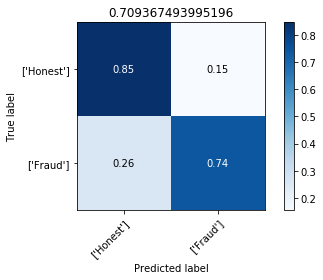

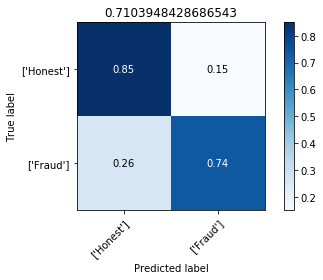

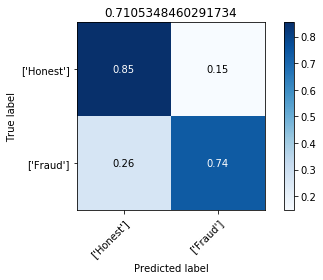

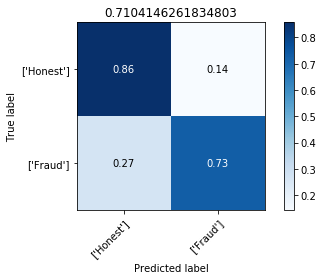

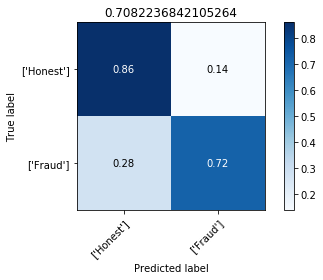

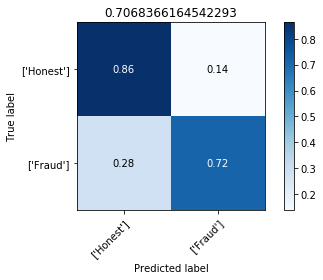

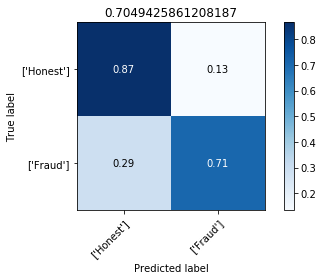

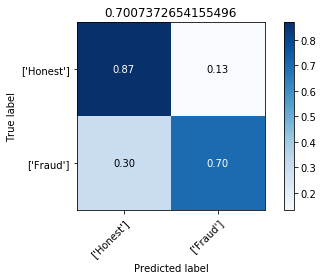

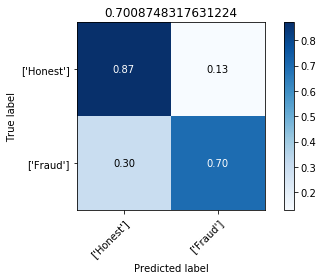

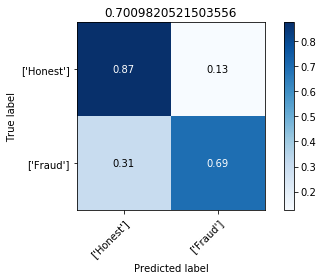

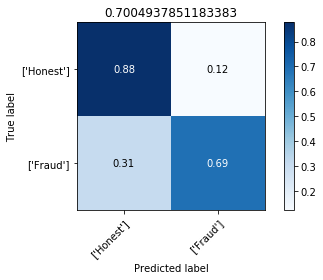

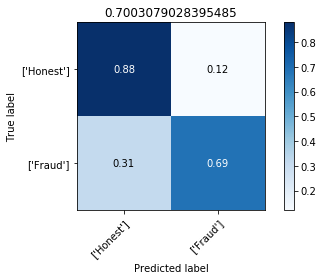

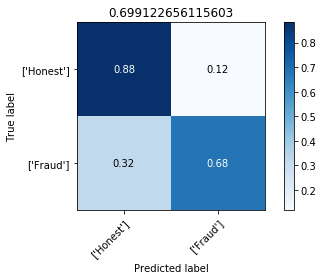

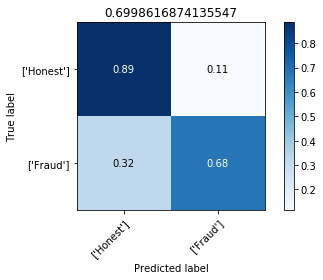

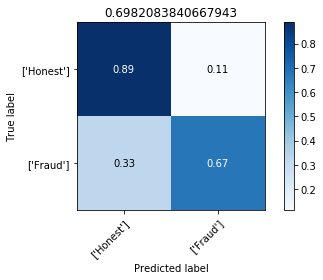

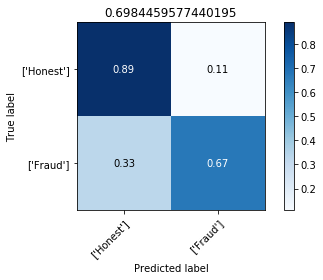

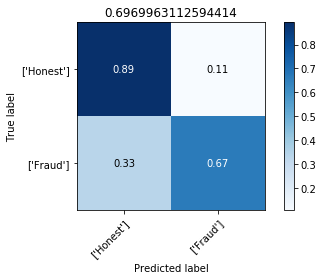

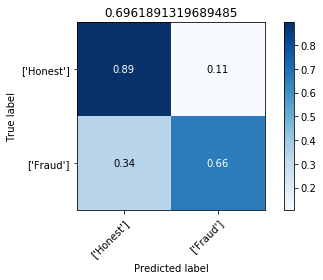

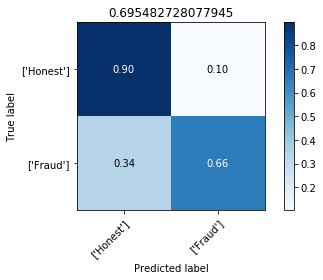

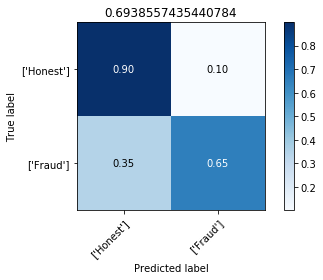

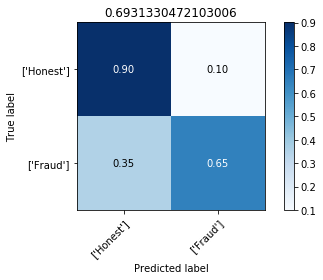

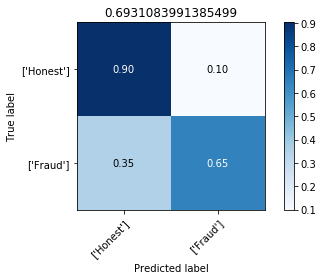

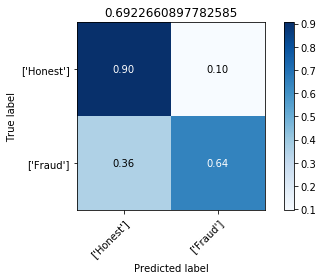

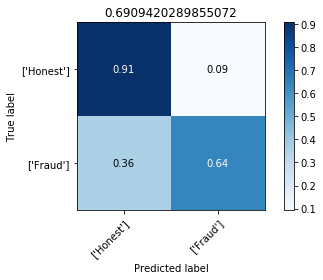

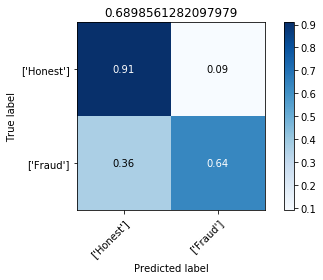

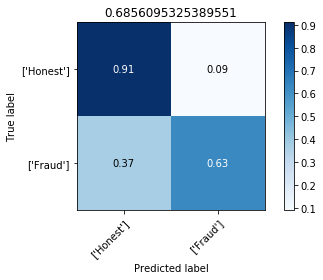

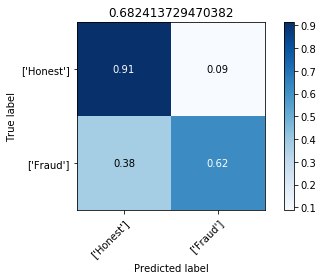

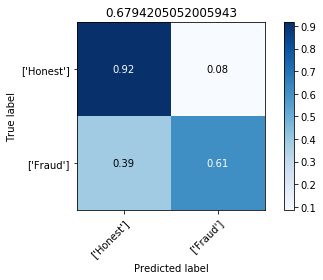

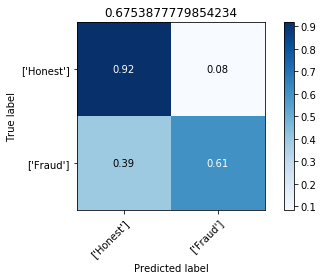

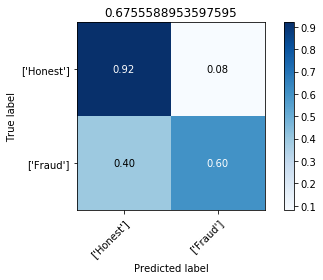

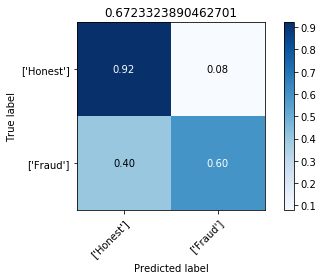

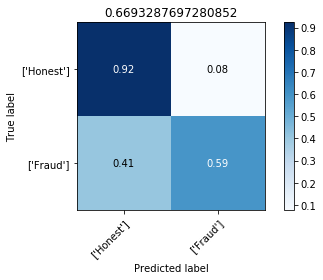

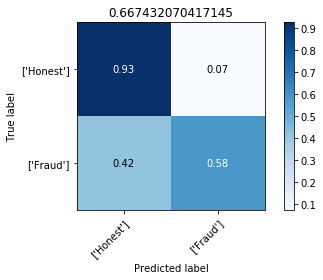

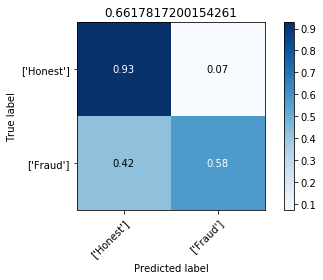

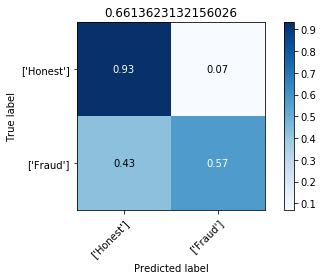

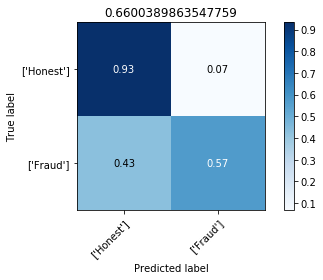

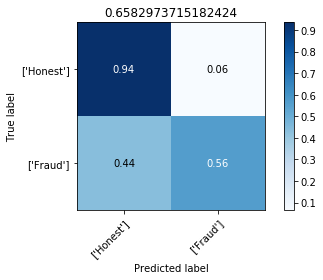

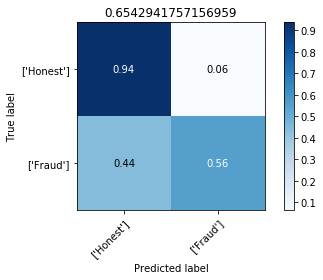

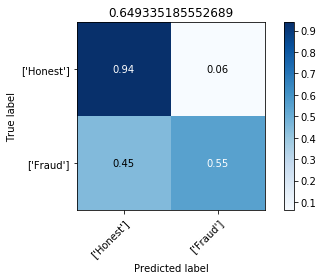

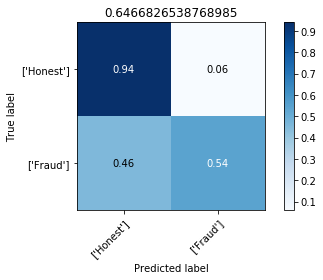

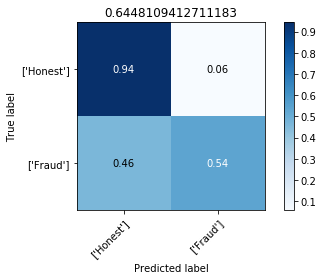

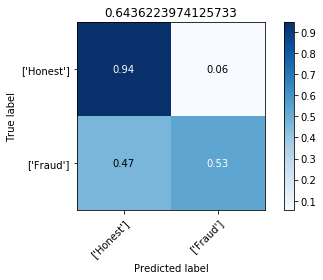

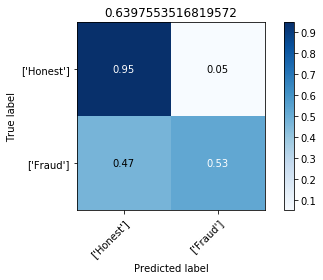

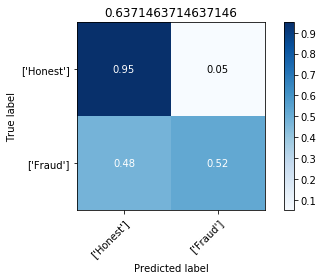

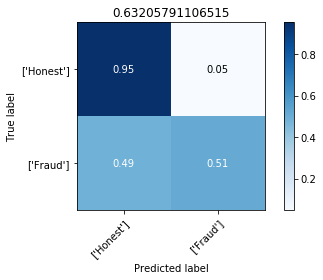

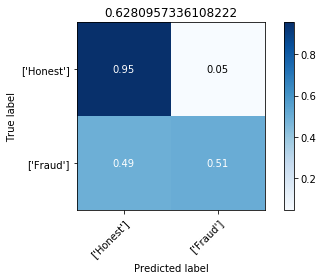

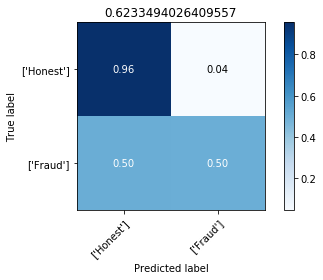

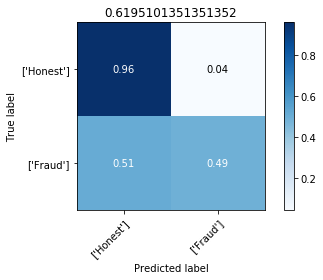

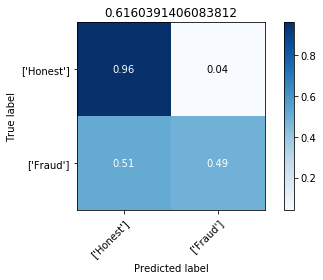

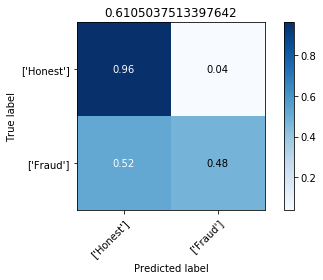

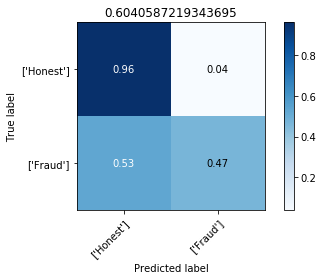

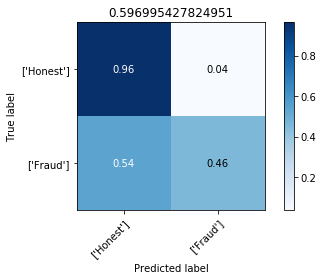

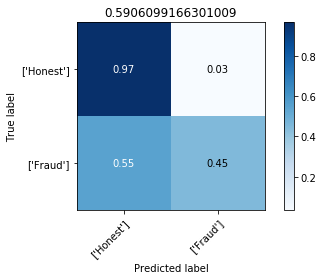

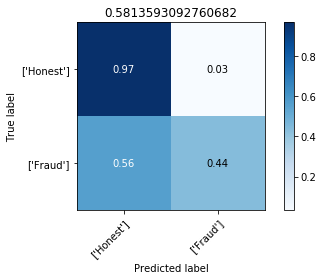

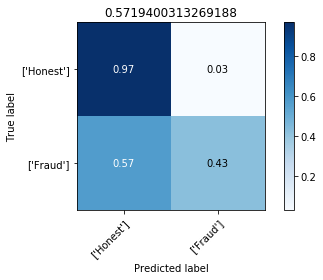

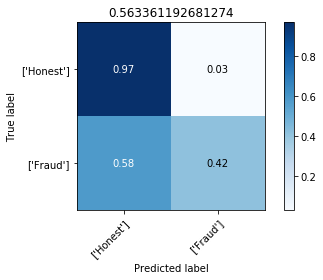

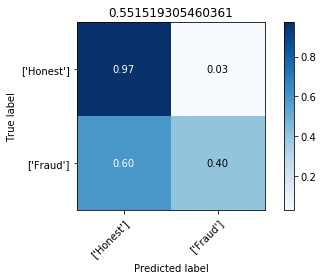

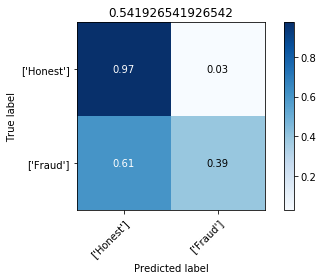

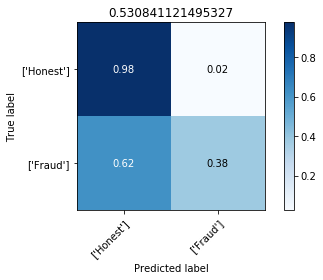

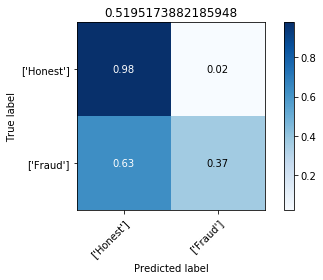

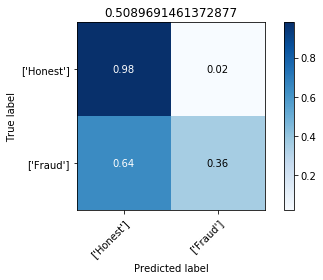

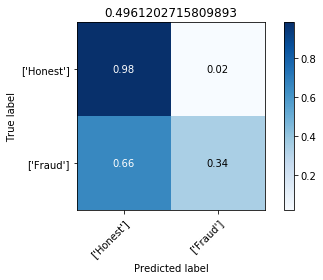

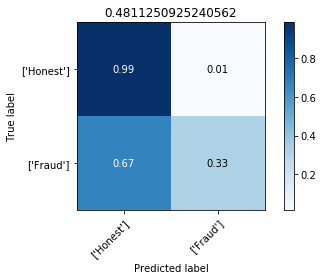

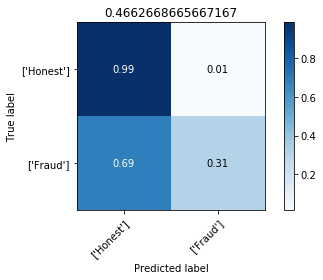

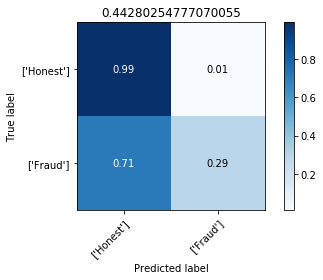

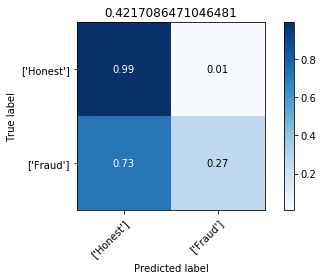

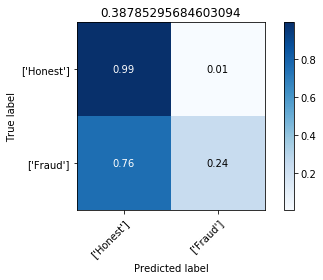

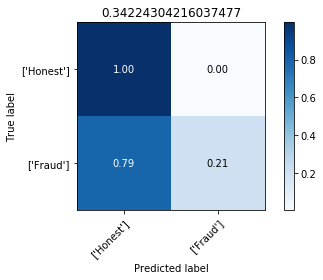

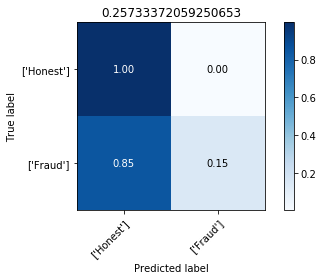

In [97]:
prob = np.ravel(model.predict_proba(x_data[1])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

- ### Predicting with the best Threshold

Normalized confusion matrix
[[9.99936330e-01 6.36699351e-05]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[0.80483847 0.19516153]
 [0.20053655 0.79946345]]
Normalized confusion matrix
[[0.80660377 0.19339623]
 [0.19986564 0.80013436]]


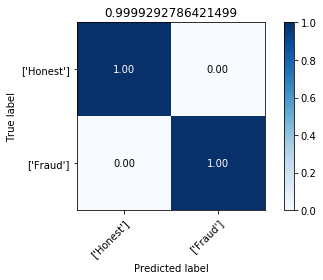

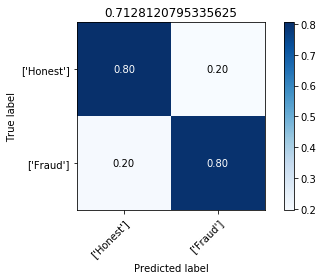

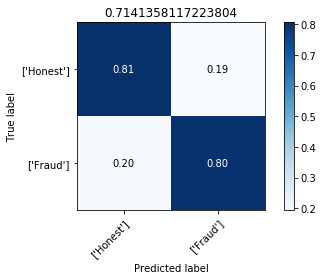

In [98]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])[:,1]),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)